A good way to do this is by working with the Prophet model. Prophet does a time series decomposition into level + trend + seasonality by just fitting some curves. The advantage of doing things this way is that it's easy to jointly model several time series together using the usual hierarchical machinery. I have an unreleased tutorial notebook here.

To close this issue, model the CO2 and Temperature data jointly. Make a model for each one separately, then jointly. The interesting parameter will be the correlation between the two trends, so you can draw the priors for the trend components jointly from a multivariate normal. The Radon notebook will be nice for this.

In [1]:
import pandas as pd
import numpy as np
import os
from os.path import exists

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

We will be modeling $CO_2$ PPM and ocean heat. We know that both of these are stock variables. Anthropogenic and natural releases of $CO_2$ increase its concentration in the atmosphere. $CO_2$ may be sequestered, however on net it is increasing. Due to greenhouse gasses such as $CO_2$, increases in their atmospheric concentration decrease the reflectivity of the sun's heat increasing the Earth's temperature. The majority of this heat is then stored as energy (ie heat) in the Earth's oceans. While we do expect some reverse causality, overall we expect increases in $CO_2$ PPM to cause increases in ocean temperature.

In [2]:
CO2_URL = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_annmean_mlo.csv"
CO2_FILENAME = "noaa_co2.csv"
OCEAN_HEAT_URL = "https://www.ncei.noaa.gov/data/oceans/woa/DATA_ANALYSIS/3M_HEAT_CONTENT/DATA/basin/3month/ohc_levitus_climdash_seasonal.csv"
# https://www.ncei.noaa.gov/access/global-ocean-heat-content/basin_heat_data_monthly.html
OCEAN_HEAT_FILENAME = "ncei_global_ocean_heat.csv"

In [3]:
def process_ocean_heat(data_path="../data"):
    if not exists(data_path):
        os.makedirs(data_path)

    if not os.path.isfile(os.path.join(data_path, OCEAN_HEAT_FILENAME)):
        df_ocean = pd.read_csv(OCEAN_HEAT_URL, header=0, names=['Date','Temp'])
        df_ocean.Date = pd.to_datetime(df_ocean.Date, format='%Y-%m')
        df_ocean.set_index("Date", inplace=True)
        df_ocean.to_csv(os.path.join(data_path, OCEAN_HEAT_FILENAME))

    else:
        df_ocean = pd.read_csv(
            os.path.join(data_path, OCEAN_HEAT_FILENAME),
            index_col=["Date"],
            parse_dates=True,
        )

    return df_ocean

In [4]:
def process_co2(data_path="../data"):
    if not exists(data_path):
        os.makedirs(data_path)

    if not os.path.isfile(os.path.join(data_path, CO2_FILENAME)):
        df_co2 = pd.read_csv(CO2_URL, skiprows=43)
        df_co2['month'] = 1
        df_co2['day'] = 1
        df_co2['Date'] = pd.to_datetime(df_co2[['year', 'month', 'day']])
        df_co2.set_index("Date", inplace=True)
        df_co2.rename(columns={"mean": "co2"}, inplace=True)
        df_co2 = df_co2[["co2"]]
        df_co2.to_csv(os.path.join(data_path, CO2_FILENAME))

    else:
        df_co2 = pd.read_csv(
            os.path.join(data_path, CO2_FILENAME), index_col=["Date"], parse_dates=True
        )

    return df_co2

In [5]:
df_ocean = process_ocean_heat()
df_co2 = process_co2()

Converting ocean heat to annual data:

In [6]:
df_ocean = df_ocean.resample('YE').mean()
df_ocean.reset_index(inplace=True)
df_ocean['Date'] = df_ocean['Date'] - pd.offsets.YearBegin()
df_ocean.set_index("Date", inplace=True)
df_ocean = df_ocean.iloc[1:-1] #Dropping first and last column with incomplete data
df_ocean = df_ocean + 152 #add back in baseline that was subtracted from the data

# $CO_2$ PPM

<Axes: xlabel='Date'>

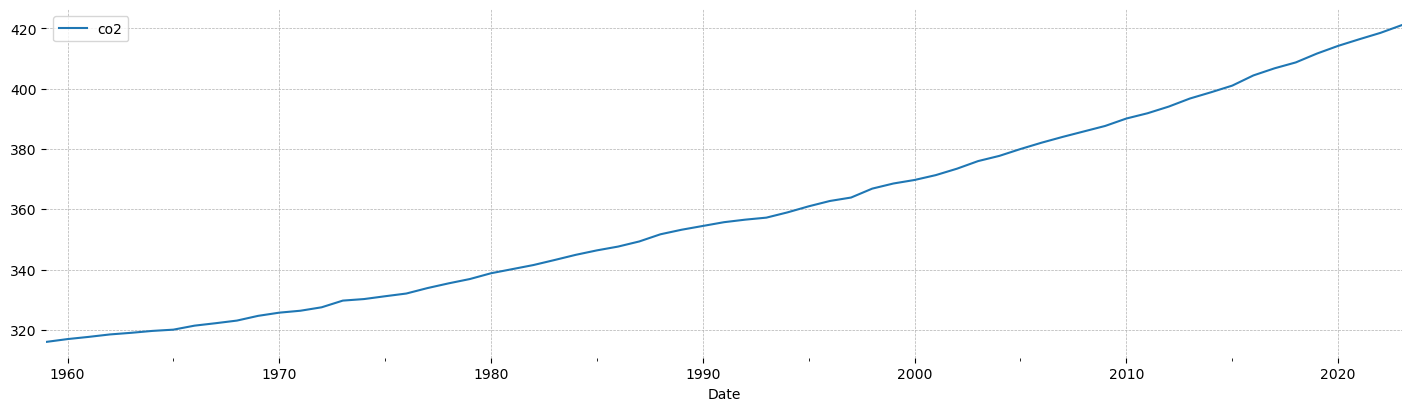

In [7]:
df_co2.plot()

In [8]:
train_df, test_df = df_co2.iloc[:round(len(df_co2)*.85)], df_co2.iloc[round(len(df_co2)*.85):]

In [9]:
# We're going to type these a lot...
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

# We need to use "coords_mutable", beause we plan to make forecasts (so we want to change the coords)
coords_mutable = {'time':train_df.index}

with pm.Model(coords_mutable=coords_mutable) as deterministic_trend_mod:
    y_obs = pm.ConstantData('y_obs', train_df.values.ravel())
    
    # Time is just a counter variable, and its actual values don't matter, as long they increase 
    # monotonically in evenly spaced steps. In this case we'll use np.arange to make time. We could
    # just as well use np.linspace. 
    t = pm.MutableData('t', np.arange(train_df.shape[0]), dims=['time'])
    
    alpha = pm.Normal('alpha', mu=300, sigma=10)
    gamma = pm.Normal('gamma', mu=0, sigma=10)
    mu = pm.Deterministic('mu', alpha + gamma * t, dims=['time'])
    
    sigma = pm.HalfNormal('sigma', sigma=10)

    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_obs, shape=t.shape[0], dims=['time'])
    
    det_trend_idata = pm.sample()
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, **POST_PRED_KWARGS)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:981: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, g

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Sampling: [y_hat]


Output()

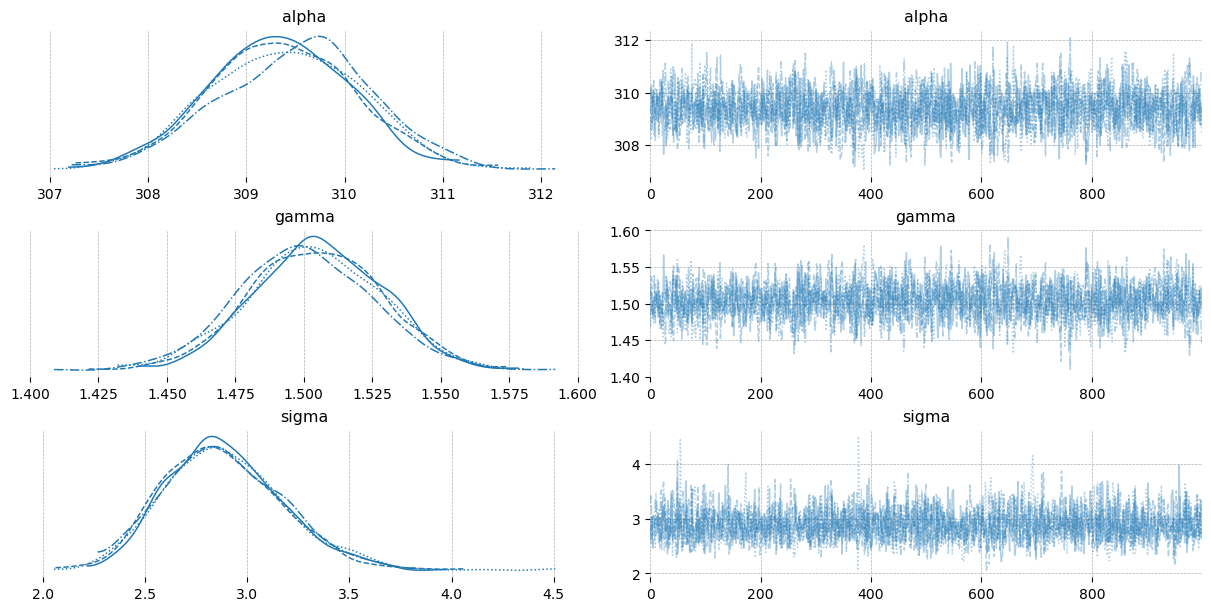

In [10]:
az.plot_trace(det_trend_idata, var_names=['~mu']);

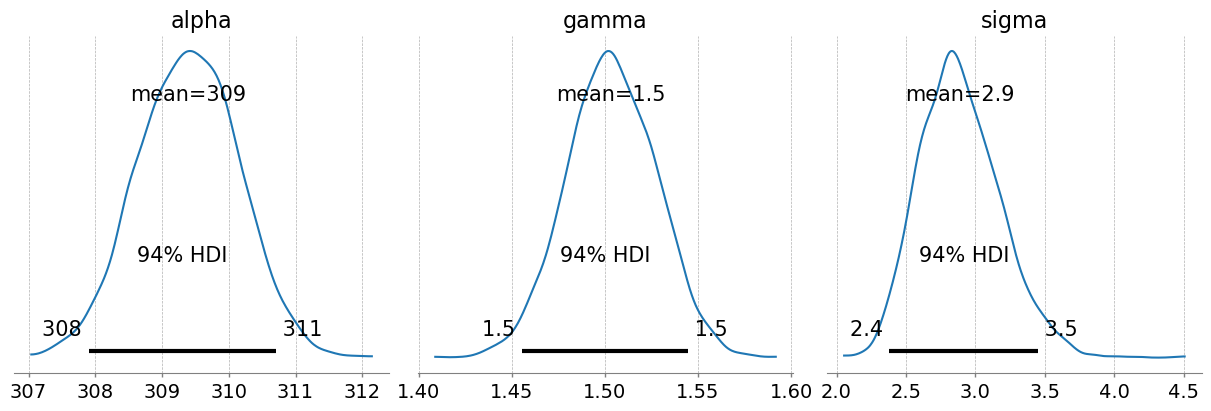

In [11]:
az.plot_posterior(det_trend_idata, 
                  var_names=['alpha', 'gamma', 'sigma'], 
                 figsize=(12,4));

In [12]:
forecast_time = np.arange(train_df.shape[0], train_df.shape[0] + test_df.shape[0])
with deterministic_trend_mod:
    pm.set_data({'t':forecast_time}, coords={'time':test_df.index})
    # Set predictions = True to put the out-of-sample predictions into the idata as a group called
    # "predictions" instead of the default "posterior_predictive"
    # (It doesn't do anything else, so don't think it will do some statistical magic for you!)
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, predictions=True, **POST_PRED_KWARGS)

Sampling: [y_hat]


Output()

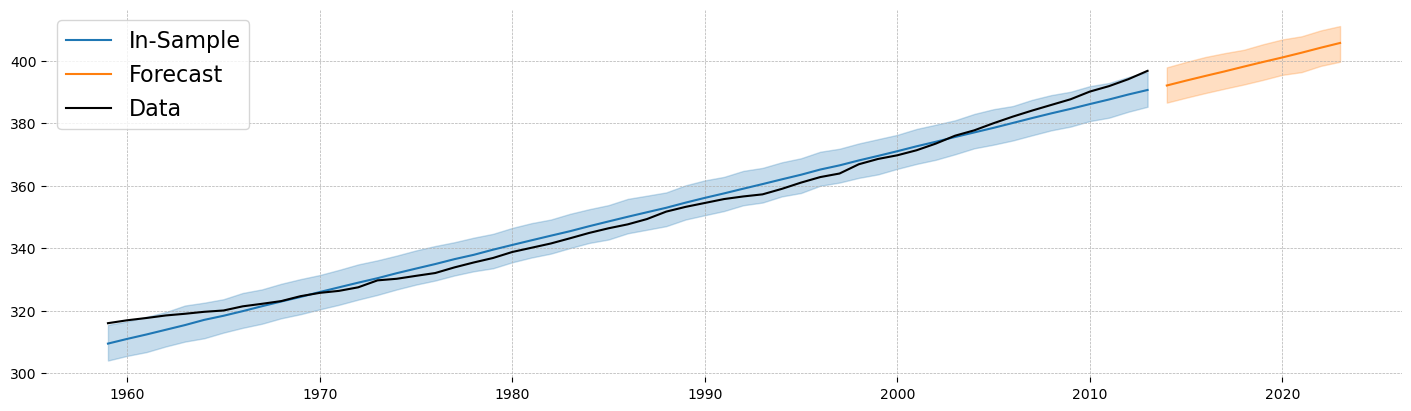

In [13]:
# We'll re-use these
def make_plot_iter():
    plotting_groups = ['posterior_predictive', 'predictions', 'constant_data']
    var_names = ['y_hat', 'y_hat', 'y_obs']
    plotting_colors = ['tab:blue', 'tab:orange', 'k']
    labels = ['In-Sample', 'Forecast', 'Data']
    return zip(plotting_groups, var_names, labels, plotting_colors)

fig, ax = plt.subplots()
for group, var_name, label, var_color in make_plot_iter():
    data = getattr(det_trend_idata, group)
    time_values = data.coords['time'].values
    if group != 'constant_data':
        hdi = az.hdi(data)[var_name]
        data = data.mean(dim=['chain', 'draw'])
        ax.fill_between(time_values, *hdi.values.T, color=var_color, alpha=0.25)
    ax.plot(time_values, data[var_name].values, c=var_color, label=label)
    ax.legend(fontsize=16)

Given the serial correlation of the errors, we need to fine-tune our model. I will be using a quadratic model since our data is stationary after taking the second difference. 

In [14]:
# We're going to type these a lot...
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

# We need to use "coords_mutable", beause we plan to make forecasts (so we want to change the coords)
coords_mutable = {'time':train_df.index}

with pm.Model(coords_mutable=coords_mutable) as deterministic_trend_mod:
    y_obs = pm.ConstantData('y_obs', train_df.values.ravel())
    
    # Time is just a counter variable, and its actual values don't matter, as long they increase 
    # monotonically in evenly spaced steps. In this case we'll use np.arange to make time. We could
    # just as well use np.linspace. 
    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])
    
    alpha = pm.Normal('alpha', mu=300, sigma=10)
    gamma_1 = pm.Normal('gamma_1', mu=0, sigma=10)
    gamma_2 = pm.Normal('gamma_2', mu=0, sigma=10)
    mu = pm.Deterministic('mu', alpha + gamma_1 * t * t + gamma_2 * t, dims=['time'])
    
    sigma = pm.HalfNormal('sigma', sigma=10)

    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_obs, shape=t.shape[0], dims=['time'])
    
    det_trend_idata = pm.sample()
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, **POST_PRED_KWARGS)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:981: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, gamma_1, gamma_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_hat]


Output()

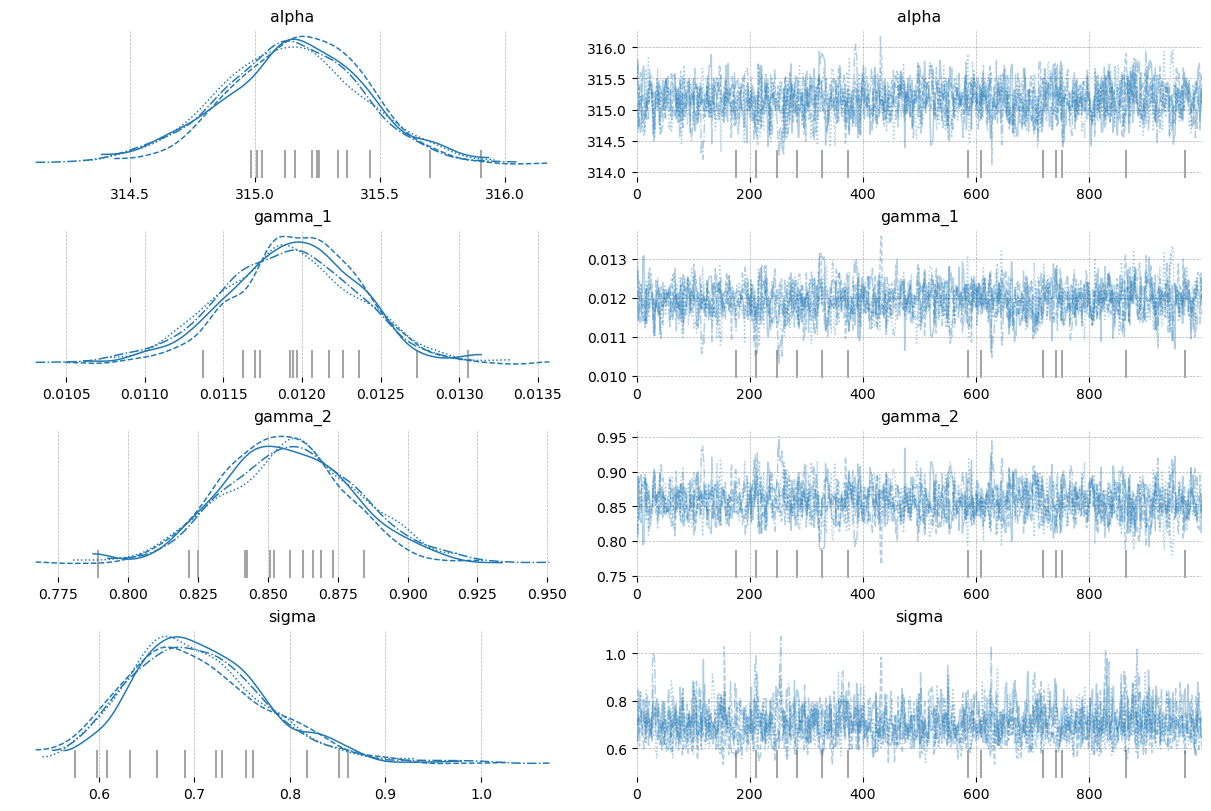

In [15]:
az.plot_trace(det_trend_idata, var_names=['~mu']);

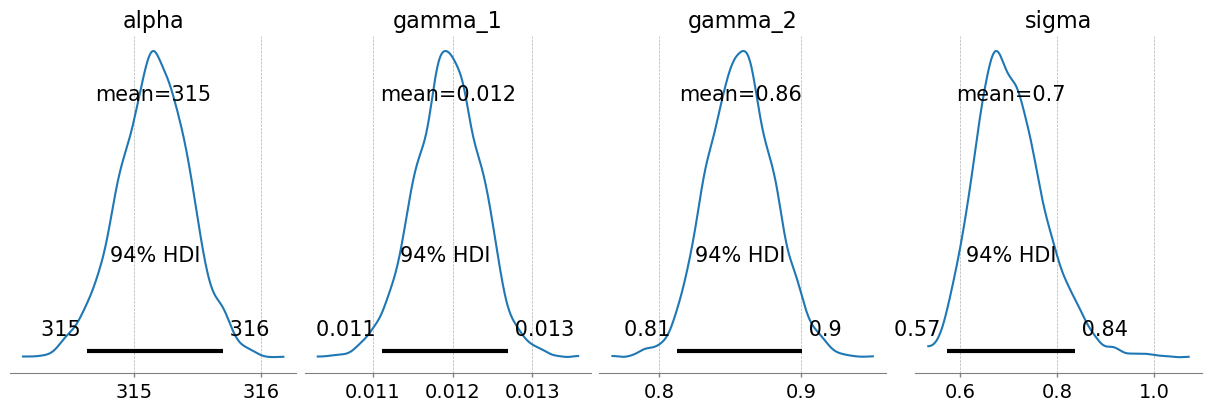

In [16]:
az.plot_posterior(det_trend_idata, 
                  var_names=['alpha', 'gamma_1','gamma_2', 'sigma'], 
                 figsize=(12,4));

In [17]:
forecast_time = np.arange(train_df.shape[0], train_df.shape[0] + test_df.shape[0])
with deterministic_trend_mod:
    pm.set_data({'t':forecast_time}, coords={'time':test_df.index})
    # Set predictions = True to put the out-of-sample predictions into the idata as a group called
    # "predictions" instead of the default "posterior_predictive"
    # (It doesn't do anything else, so don't think it will do some statistical magic for you!)
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, predictions=True, **POST_PRED_KWARGS)

Sampling: [y_hat]


Output()

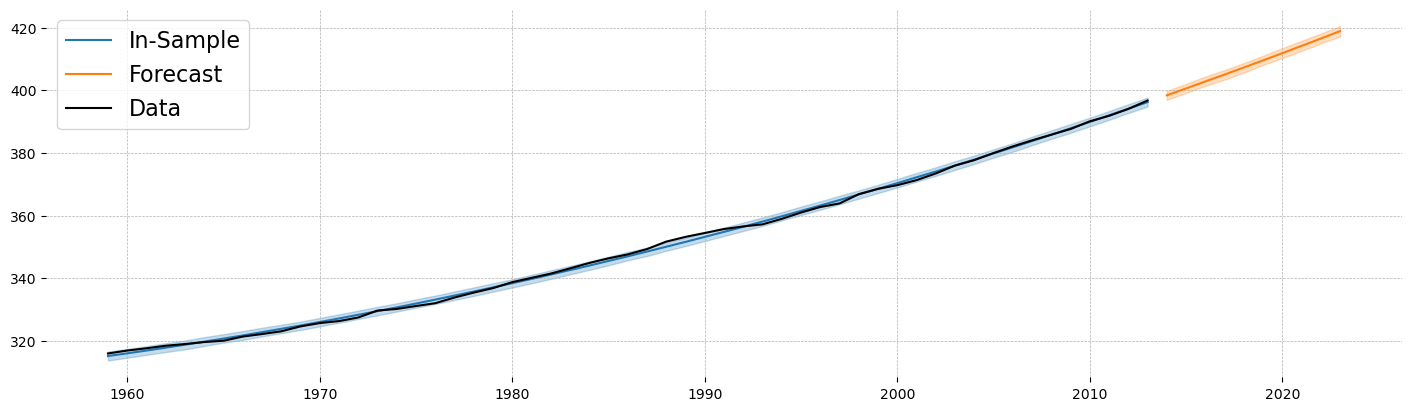

In [18]:
# We'll re-use these
def make_plot_iter():
    plotting_groups = ['posterior_predictive', 'predictions', 'constant_data']
    var_names = ['y_hat', 'y_hat', 'y_obs']
    plotting_colors = ['tab:blue', 'tab:orange', 'k']
    labels = ['In-Sample', 'Forecast', 'Data']
    return zip(plotting_groups, var_names, labels, plotting_colors)

fig, ax = plt.subplots()
for group, var_name, label, var_color in make_plot_iter():
    data = getattr(det_trend_idata, group)
    time_values = data.coords['time'].values
    if group != 'constant_data':
        hdi = az.hdi(data)[var_name]
        data = data.mean(dim=['chain', 'draw'])
        ax.fill_between(time_values, *hdi.values.T, color=var_color, alpha=0.25)
    ax.plot(time_values, data[var_name].values, c=var_color, label=label)
    ax.legend(fontsize=16)

<Axes: xlabel='Date'>

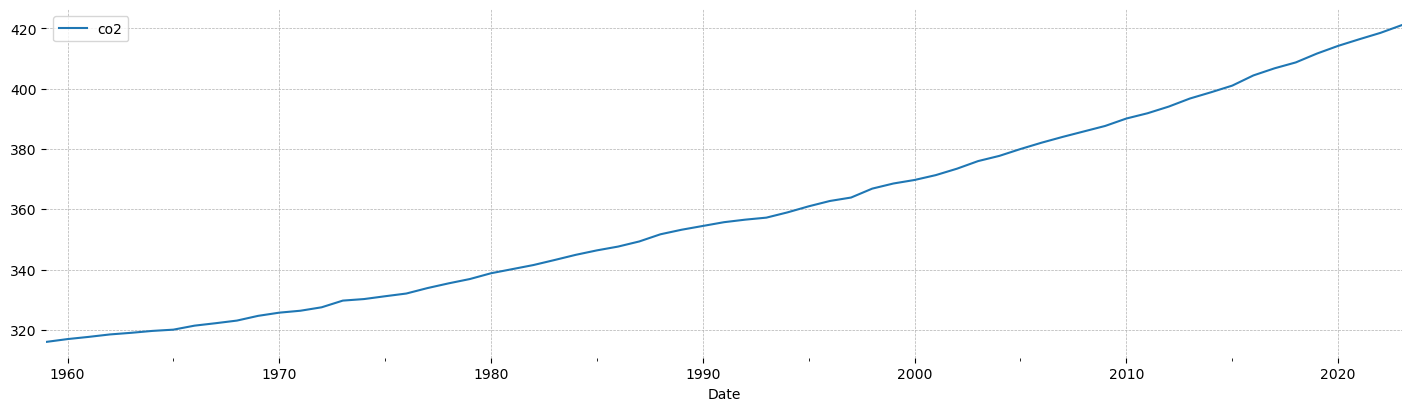

In [19]:
df_co2.plot()

# Ocean Heat

<Axes: xlabel='Date'>

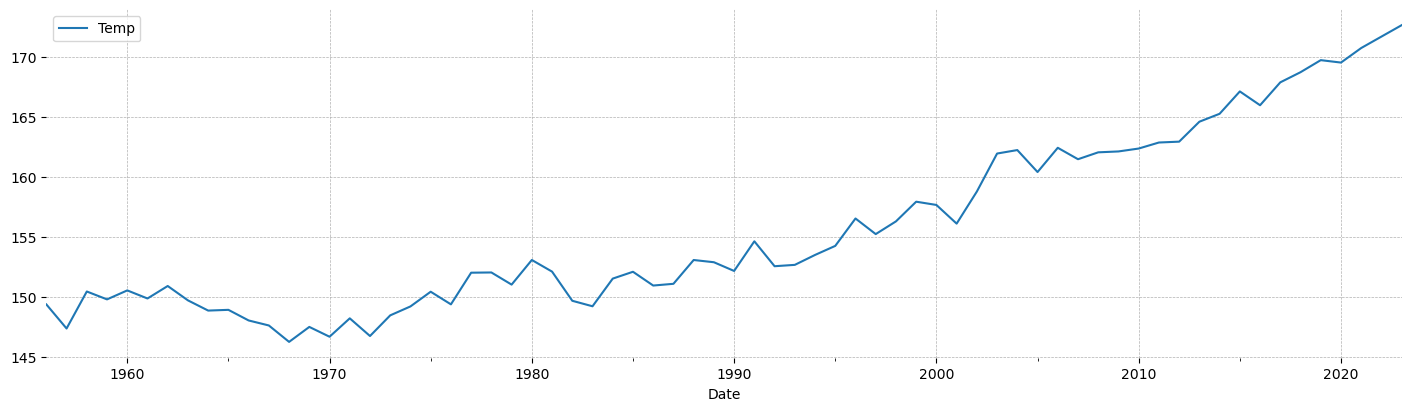

In [20]:
df_ocean.plot()

In [21]:
train_df, test_df = df_ocean.iloc[:round(len(df_ocean)*.85)], df_ocean.iloc[round(len(df_ocean)*.85):]

In [22]:
# We're going to type these a lot...
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

# We need to use "coords_mutable", beause we plan to make forecasts (so we want to change the coords)
coords_mutable = {'time':train_df.index}

with pm.Model(coords_mutable=coords_mutable) as deterministic_trend_mod:
    y_obs = pm.ConstantData('y_obs', train_df.values.ravel())
    
    # Time is just a counter variable, and its actual values don't matter, as long they increase 
    # monotonically in evenly spaced steps. In this case we'll use np.arange to make time. We could
    # just as well use np.linspace. 
    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])
    
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    gamma_1 = pm.Normal('gamma_1', mu=0, sigma=10)
    gamma_2 = pm.Normal('gamma_2', mu=0, sigma=10)
    mu = pm.Deterministic('mu', alpha + gamma_1 * t * t + gamma_2 * t, dims=['time'])
    
    sigma = pm.HalfNormal('sigma', sigma=10)

    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_obs, shape=t.shape[0], dims=['time'])
    
    det_trend_idata = pm.sample()
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, **POST_PRED_KWARGS)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:981: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, gamma_1, gamma_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
Sampling: [y_hat]


Output()

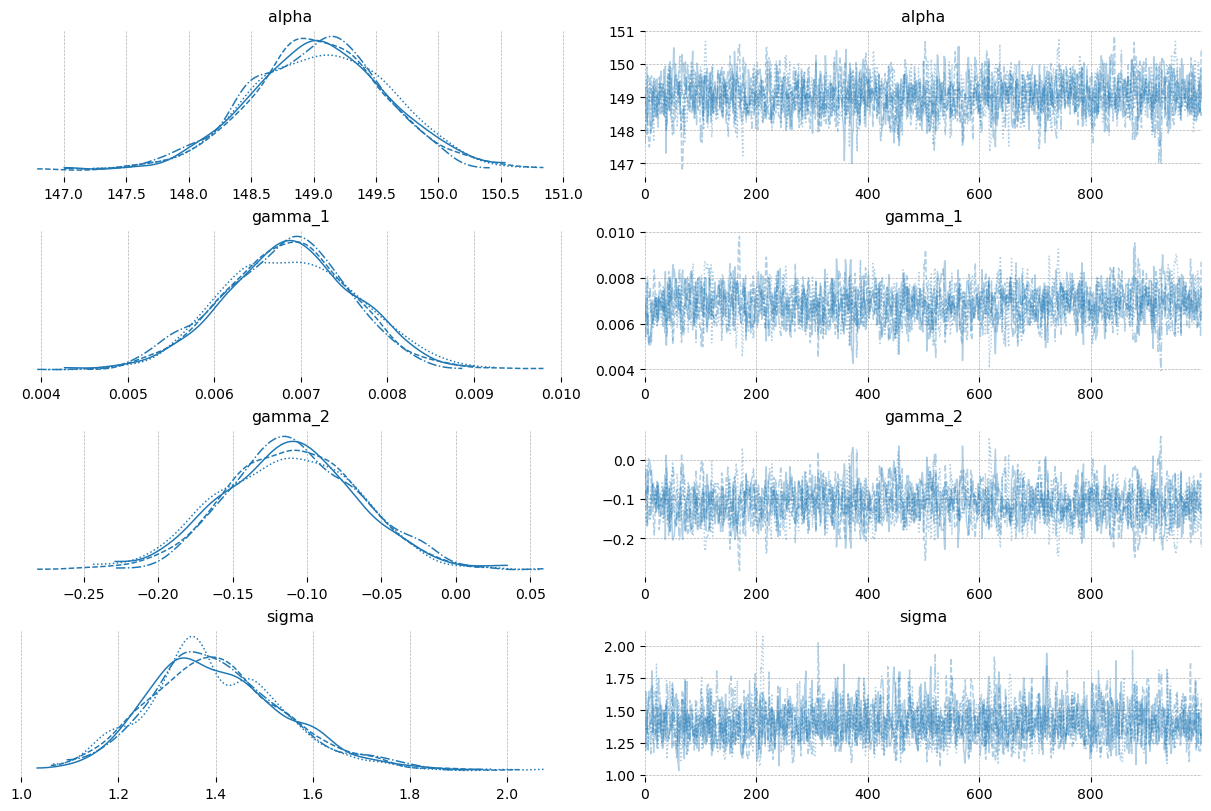

In [23]:
az.plot_trace(det_trend_idata, var_names=['~mu']);

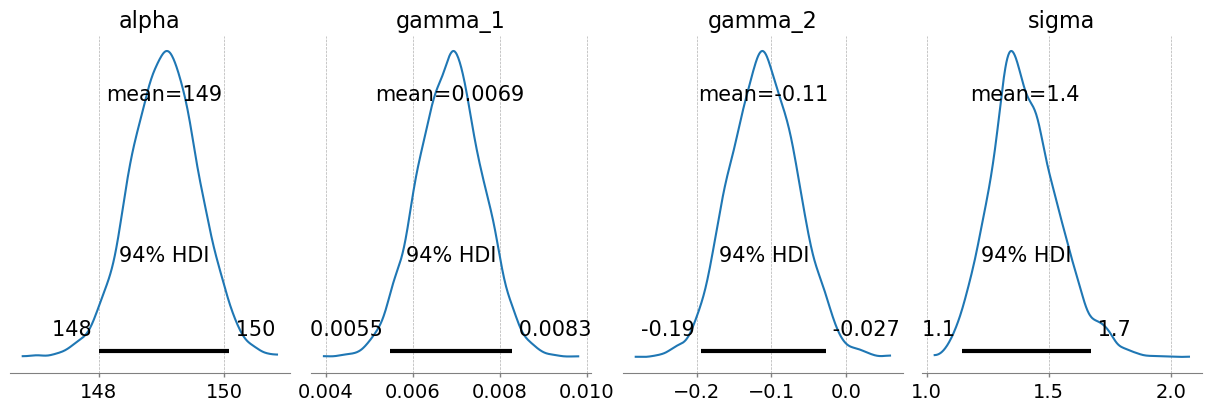

In [24]:
az.plot_posterior(det_trend_idata, 
                  var_names=['alpha', 'gamma_1','gamma_2', 'sigma'], 
                 figsize=(12,4));

In [25]:
forecast_time = np.arange(train_df.shape[0], train_df.shape[0] + test_df.shape[0])
with deterministic_trend_mod:
    pm.set_data({'t':forecast_time}, coords={'time':test_df.index})
    # Set predictions = True to put the out-of-sample predictions into the idata as a group called
    # "predictions" instead of the default "posterior_predictive"
    # (It doesn't do anything else, so don't think it will do some statistical magic for you!)
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, predictions=True, **POST_PRED_KWARGS)

Sampling: [y_hat]


Output()

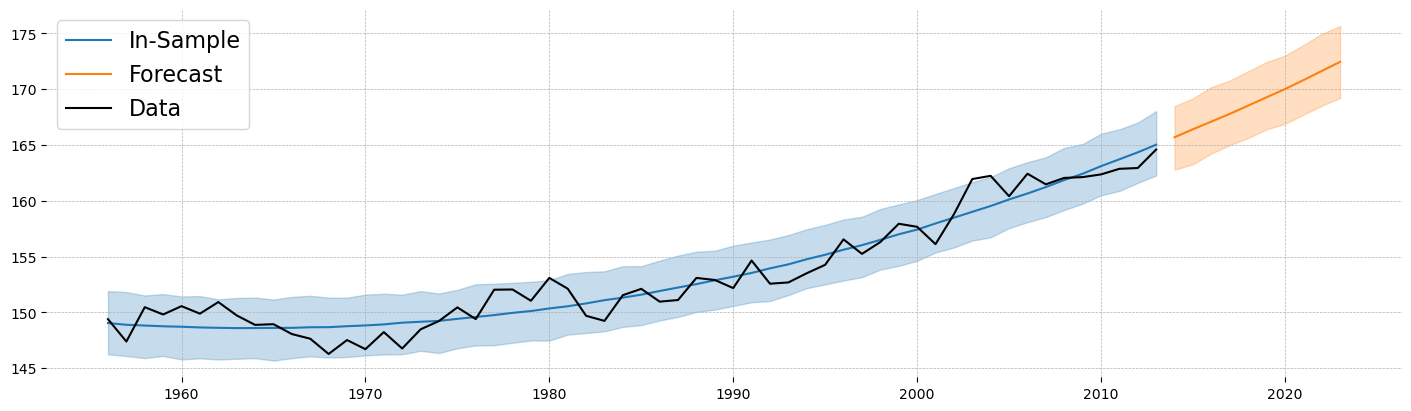

In [26]:
# We'll re-use these
def make_plot_iter():
    plotting_groups = ['posterior_predictive', 'predictions', 'constant_data']
    var_names = ['y_hat', 'y_hat', 'y_obs']
    plotting_colors = ['tab:blue', 'tab:orange', 'k']
    labels = ['In-Sample', 'Forecast', 'Data']
    return zip(plotting_groups, var_names, labels, plotting_colors)

fig, ax = plt.subplots()
for group, var_name, label, var_color in make_plot_iter():
    data = getattr(det_trend_idata, group)
    time_values = data.coords['time'].values
    if group != 'constant_data':
        hdi = az.hdi(data)[var_name]
        data = data.mean(dim=['chain', 'draw'])
        ax.fill_between(time_values, *hdi.values.T, color=var_color, alpha=0.25)
    ax.plot(time_values, data[var_name].values, c=var_color, label=label)
    ax.legend(fontsize=16)

On a log scale, it seems like it has had a constant increase since 1968. We are adding 10 to the variable to make the data positive.

<Axes: xlabel='Date'>

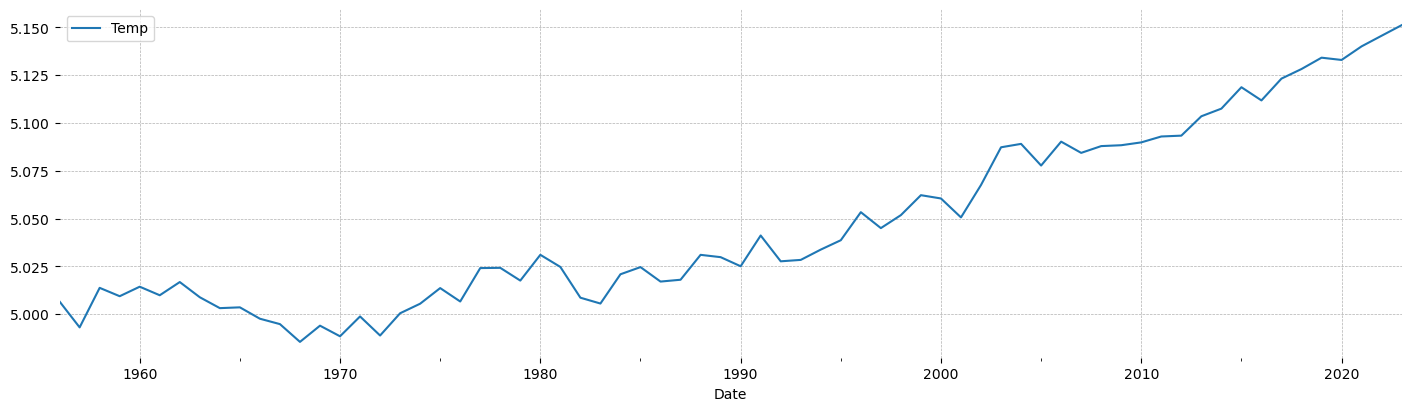

In [27]:
np.log(df_ocean).plot()

In [28]:
train_df, test_df = df_ocean.iloc[12:55], df_ocean.iloc[55:]

In [29]:
# We're going to type these a lot...
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

# We need to use "coords_mutable", beause we plan to make forecasts (so we want to change the coords)
coords_mutable = {'time':train_df.index}

with pm.Model(coords_mutable=coords_mutable) as deterministic_trend_mod:
    y_obs = pm.ConstantData('y_obs', np.log(train_df.values.ravel()+10))
    
    # Time is just a counter variable, and its actual values don't matter, as long they increase 
    # monotonically in evenly spaced steps. In this case we'll use np.arange to make time. We could
    # just as well use np.linspace. 
    t = pm.MutableData('t', np.arange(train_df.shape[0]), dims=['time'])
    
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    gamma_1 = pm.Normal('gamma_1', mu=0, sigma=10)
    mu = pm.Deterministic('mu', alpha + gamma_1 * t, dims=['time'])
    
    sigma = pm.HalfNormal('sigma', sigma=10)

    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_obs, shape=t.shape[0], dims=['time'])
    
    det_trend_idata = pm.sample()
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, **POST_PRED_KWARGS)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:981: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, g

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Sampling: [y_hat]


Output()

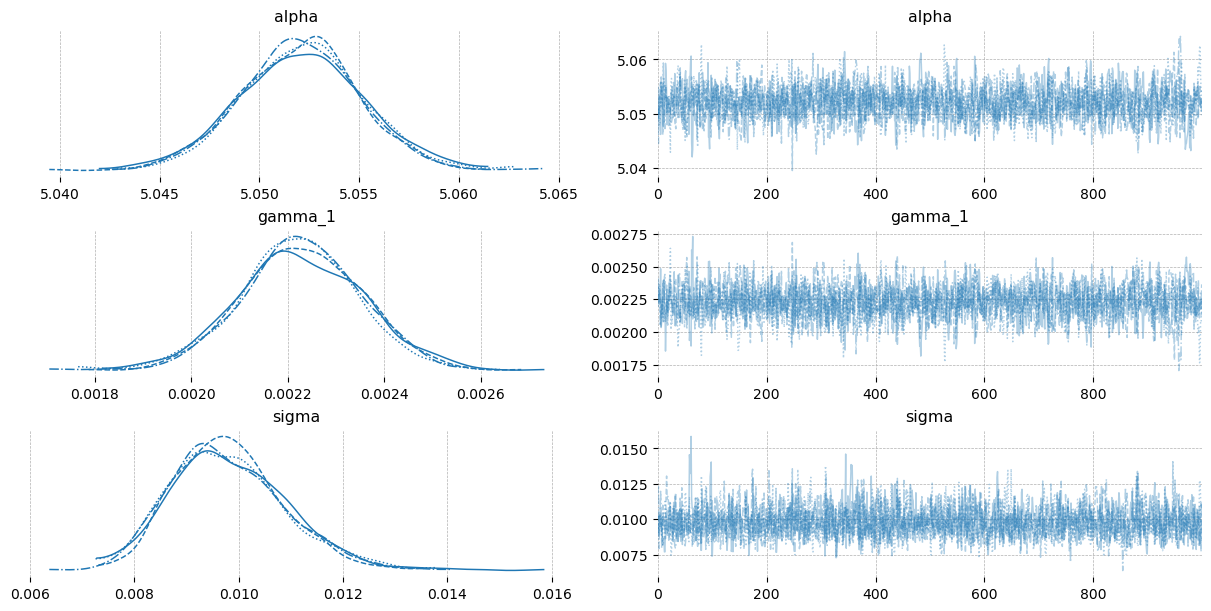

In [30]:
az.plot_trace(det_trend_idata, var_names=['~mu']);

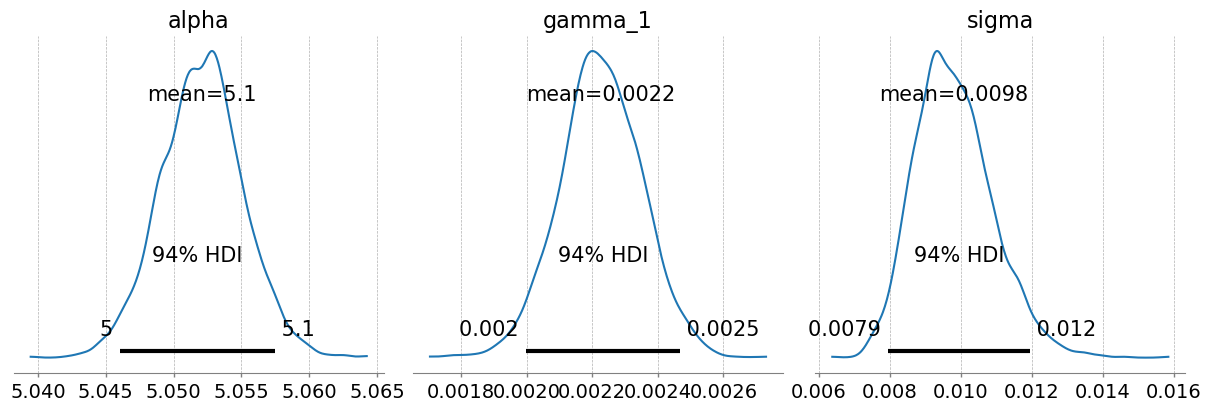

In [31]:
az.plot_posterior(det_trend_idata, 
                  var_names=['alpha', 'gamma_1', 'sigma'], 
                 figsize=(12,4));

In [32]:
forecast_time = np.arange(train_df.shape[0], train_df.shape[0] + test_df.shape[0])
with deterministic_trend_mod:
    pm.set_data({'t':forecast_time}, coords={'time':test_df.index})
    # Set predictions = True to put the out-of-sample predictions into the idata as a group called
    # "predictions" instead of the default "posterior_predictive"
    # (It doesn't do anything else, so don't think it will do some statistical magic for you!)
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, predictions=True, **POST_PRED_KWARGS)

Sampling: [y_hat]


Output()

Well, looking at our results I prefer the quadratic model

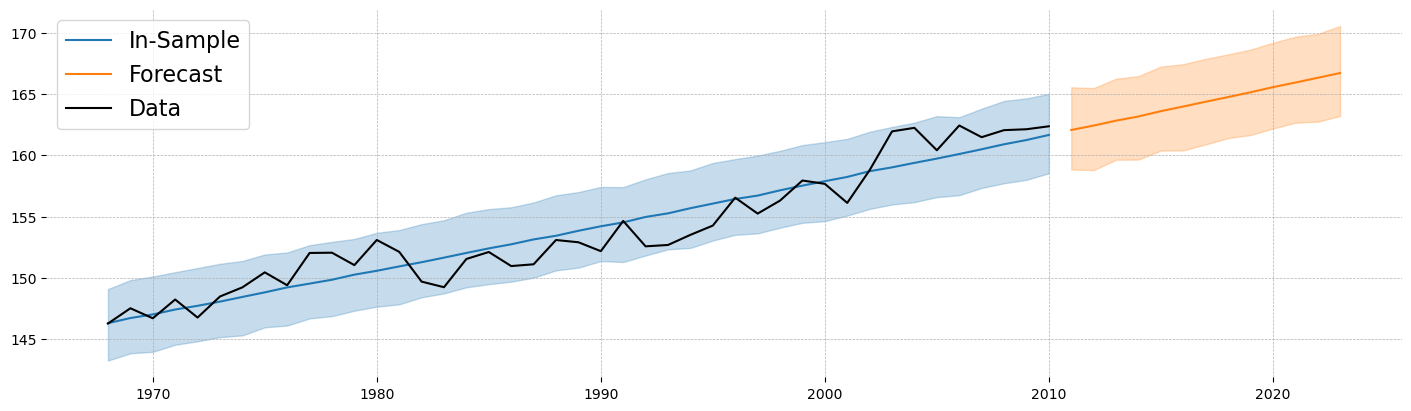

In [33]:
# We'll re-use these
def make_plot_iter():
    plotting_groups = ['posterior_predictive', 'predictions', 'constant_data']
    var_names = ['y_hat', 'y_hat', 'y_obs']
    plotting_colors = ['tab:blue', 'tab:orange', 'k']
    labels = ['In-Sample', 'Forecast', 'Data']
    return zip(plotting_groups, var_names, labels, plotting_colors)

fig, ax = plt.subplots()
for group, var_name, label, var_color in make_plot_iter():
    data = getattr(det_trend_idata, group)
    time_values = data.coords['time'].values
    if group != 'constant_data':
        hdi = np.e**az.hdi(data)[var_name]-10
        data = data.mean(dim=['chain', 'draw'])
        ax.fill_between(time_values, *hdi.values.T, color=var_color, alpha=0.25)
    ax.plot(time_values, np.e**data[var_name].values-10, c=var_color, label=label)
    ax.legend(fontsize=16)

In [34]:
train_df, test_df = df_ocean.iloc[:round(len(df_ocean)*.85)], df_ocean.iloc[round(len(df_ocean)*.85):]
n_changepoints = round(len(train_df)/5)

# We're going to type these a lot...
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

# We need to use "coords_mutable", beause we plan to make forecasts (so we want to change the coords)
coords_mutable = {'time':train_df.index}

In [35]:
def create_piecewise_trend(t, t_max, n_changepoints): 
    """
    Generates features for the piecewise linear trend model.
    
    Parameters
    ----------
    t: TensorVariable
        Evenly-spaced time counter of shape (T,). Should be monotonically increasing.
    t_max: int
        Max value of time in the training data. This argumeent ensures that we can re-use this function 
        for forecasting (in that case, the A matrix should be all ones)
    n_changepoints: int
        Number of changes to allow to the trend
    
    Returns
    -------
    A: TensorVariable
        Indicator matrix showing which trends to apply at each timestep. Shape is (T, n_changepoints)
    s: TensorVariable
        Vector of changepoints values. Shape is (n_changepoints, )
    """
    
    s = pt.linspace(0, t_max, n_changepoints+2)[1:-1]
    A = (t[:, None] > s)*1
    
    return A, s

In [36]:
coords_mutable = {'time':train_df.index}

T_max = train_df.shape[0]

# Make coords for the initial values, and for the breakpoints
coords = {'params': ['initial_intercept', 'initial_slope'],
          'breakpoint':np.arange(n_changepoints, dtype='int')}

with pm.Model(coords=coords, coords_mutable=coords_mutable) as breakpoint_mod:
    y_obs = pm.Data('y_obs', train_df.values.ravel())
    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])

    A, s = create_piecewise_trend(t, T_max, n_changepoints)
    
    initials = pm.Normal('initial', mu=0, sigma=1, dims=['params'])
    offsets = pm.Normal('offsets', mu=0, sigma=1, dims=['breakpoint'])
    
    # Save the time series components for later analysis
    intercept = pm.Deterministic('intercept', initials[0] + ((-s * A) * offsets).sum(axis=1), dims=['time'])
    slope = pm.Deterministic('slope', initials[1] + (A * offsets).sum(axis=1), dims=['time'])
    trend = pm.Deterministic('trend', intercept + slope * t, dims=['time'])

    alpha = pm.Normal('alpha', mu=150, sigma=10)

    mu = pm.Deterministic('mu', trend+alpha, dims=['time'])
    sigma = pm.HalfNormal('sigma', sigma=1)

    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_obs, shape=t.shape[0], dims=['time'])
    
    # Save the model residuals for plotting later
    resid = pm.Deterministic('residuals', y_obs - mu, dims=['time'])
    
    breakpoint_idata = pm.sample(target_accept=.9)
    breakpoint_idata = pm.sample_posterior_predictive(breakpoint_idata, **POST_PRED_KWARGS)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:981: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [initial, offsets, alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 157 seconds.
Sampling: [y_hat]


Output()

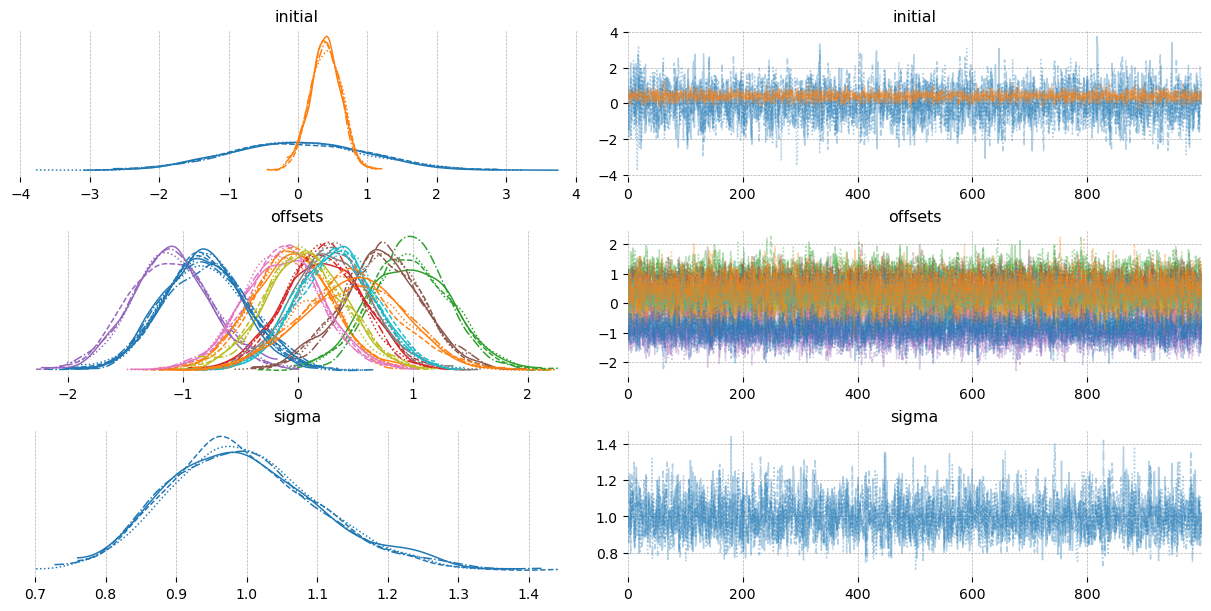

In [37]:
az.plot_trace(breakpoint_idata, var_names=['initial', 'offsets', 'sigma']);

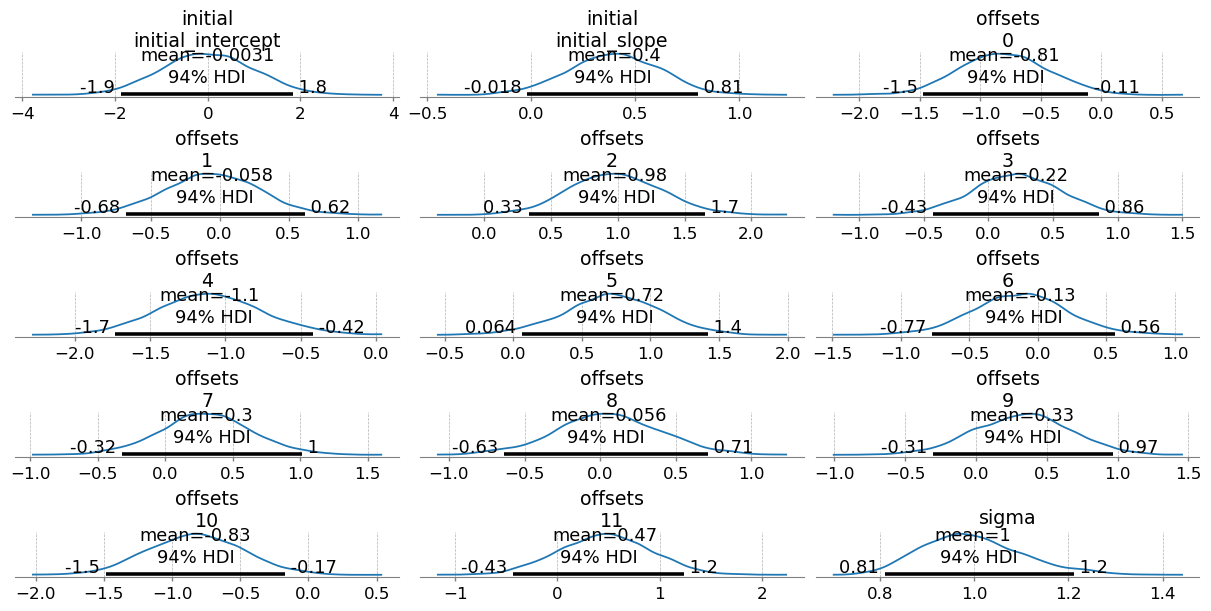

In [38]:
az.plot_posterior(breakpoint_idata, 
                  var_names=['initial', 'offsets', 'sigma'],
                 figsize=(12,6),
                  textsize=12);


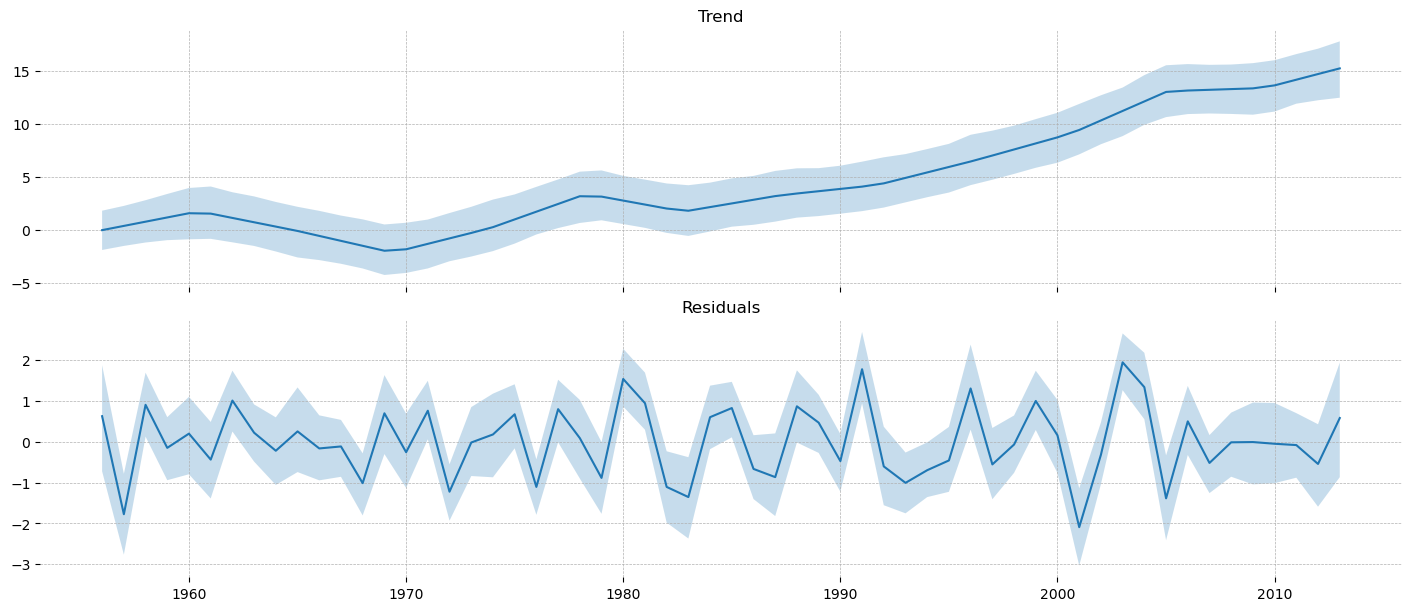

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True)

for axis, variable in zip(fig.axes, ['trend', 'residuals']):
    # Pull out the component of interest
    data = breakpoint_idata.posterior[variable]

    # Compute the mean of the samples
    mu = data.mean(dim=['chain', 'draw'])

    # Compute the HDI ("error bars")
    hdi = az.hdi(data)[variable]

    # Plot them together
    axis.plot(data.time, mu)
    axis.fill_between(data.time, *hdi.values.T, alpha=0.25)
    axis.set_title(variable.title())
plt.show()


In [40]:
forecast_time = np.arange(train_df.shape[0], train_df.shape[0] + test_df.shape[0])
with breakpoint_mod:
    pm.set_data({'t':forecast_time}, coords={'time':test_df.index})
    # Set predictions = True to put the out-of-sample predictions into the idata as a group called
    # "predictions" instead of the default "posterior_predictive"
    # (It doesn't do anything else, so don't think it will do some statistical magic for you!)
    breakpoint_idata = pm.sample_posterior_predictive(breakpoint_idata, predictions=True, **POST_PRED_KWARGS)


Sampling: [y_hat]


Output()

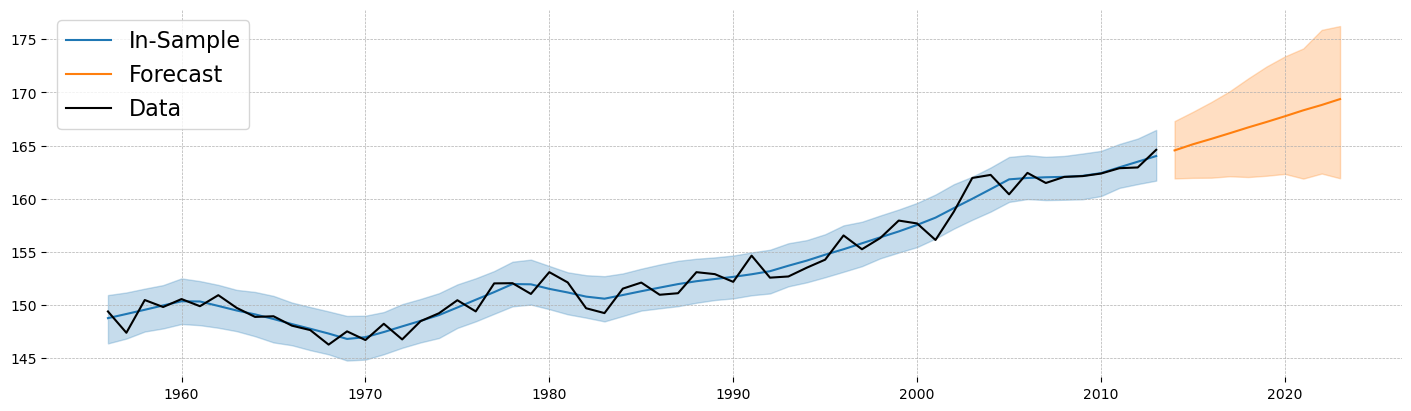

In [41]:
fig, ax = plt.subplots()
for group, var_name, label, var_color in make_plot_iter():
    data = getattr(breakpoint_idata, group)
    time_values = data.coords['time'].values
    if group != 'constant_data':
        hdi = az.hdi(data)[var_name]
        data = data.mean(dim=['chain', 'draw'])
        ax.fill_between(time_values, *hdi.values.T, color=var_color, alpha=0.25)
    ax.plot(time_values, data[var_name].values, c=var_color, label=label)
    ax.legend(fontsize=16)


<Axes: xlabel='Date'>

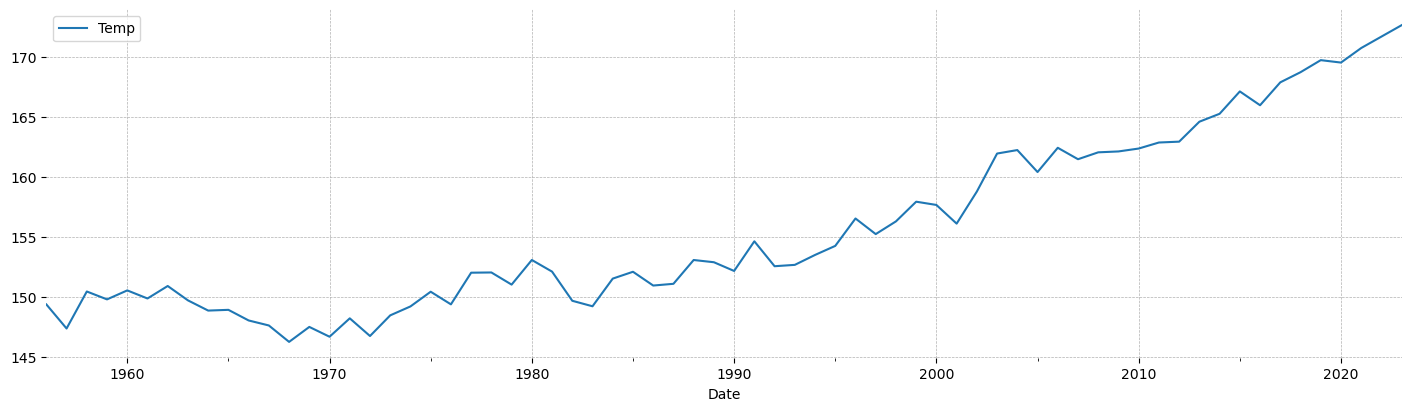

In [42]:
df_ocean.plot()

In [43]:
def create_fourier_features(t, n, p=5, backend='pt'):
    """
    Generates Fourier basis vectors to model seasonal patterns. 
    
    Parameters
    ----------
    t: TensorVariable
        Evenly-spaced time counter of shape (T,). Should be monotonically increasing.
    n: int
        Number of basis vectors to create. When n = p/2, the model is saturated and any function can be
        represented. n < p/2 learns simpler patterns. n > p/2 is not identified.
    p: float
        Length of one seasonal cycle, **in units of t**. Must be adjusted for spacing if Δt != 1!
    backend: str, one of pt or np
        Which backend to use to create features. Use "pt" instead a PyMC model, and "np" to generate
        fake data.
    
    Returns
    -------
    X: TensorVariable
        Matrix of Fourier basis vectors. Shape is (T, 2 * n)
    """

    if backend == 'pt':
        bk = pt
    elif backend == 'np':
        bk = np
    x = 2 * np.pi * (bk.arange(n)+1) * t[:, None] / p
    return bk.concatenate((bk.cos(x), bk.sin(x)), axis = 1)

In [44]:
len(train_df)

58

In [45]:
train_df, test_df = df_ocean.iloc[:round(len(df_ocean)*.85)], df_ocean.iloc[round(len(df_ocean)*.85):]

n_timesteps = round(len(df_ocean)*.85)
n_changepoints = round(len(train_df)/5)
p = 20 # Decade cycle
n = 10 # Saturated model

coords = {'params': ['initial_intercept', 'initial_slope'],
          'fourier_features':[f'{func}_{i}' for func in ['cos', 'sin'] for i in range(n)],
          'breakpoint':np.arange(n_changepoints, dtype='int'),
          'time':train_df.index}

SAMPLING_KWARGS = dict(nuts_sampler='nutpie', chains=8, draws=500)

In [46]:
with pm.Model(coords=coords) as seasonality_mod:
    y_obs = pm.Data('y_obs', train_df.values.ravel())
    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])
    T_max = t.max().eval()
    A, s = create_piecewise_trend(t, T_max, n_changepoints)
    X_fourier = create_fourier_features(t, n=n, p=p)
    
    initials = pm.Laplace('initial', mu=0, b=.5, dims=['params'])
    offsets = pm.Laplace('offsets', mu=0, b=0.1, dims=['breakpoint'])
    beta_fourier = pm.Laplace('beta_fourier', mu=0, b=0.2, dims=['fourier_features'])

    alpha = pm.Normal('alpha', mu=150, sigma=10)
    
    # Save the time series components for later analysis
    intercept = pm.Deterministic('intercept', initials[0] + ((-s * A) * offsets).sum(axis=1), dims=['time'])
    slope = pm.Deterministic('slope', initials[1] + (A * offsets).sum(axis=1), dims=['time'])
    trend = pm.Deterministic('trend', alpha + intercept + slope * t, dims=['time'])
    seasonality = pm.Deterministic('seasonality', X_fourier @ beta_fourier, dims=['time'])

    mu = pm.Deterministic('mu', trend + seasonality, dims=['time'])
    sigma = pm.HalfNormal('sigma', sigma=10)

    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_obs, shape=t.shape[0], dims=['time'])
    # y_hat_unnormed = unnormalize_data(y_hat, scaler.mean_, scaler.scale_)
    resid = pm.Deterministic('residuals', y_obs - mu, dims=['time'])
    
    seasonality_idata = pm.sample(**SAMPLING_KWARGS)
    seasonality_idata = pm.compute_log_likelihood(seasonality_idata)
    seasonality_idata = pm.sample_posterior_predictive(seasonality_idata, **POST_PRED_KWARGS)

Output()

Sampling: [y_hat]


Output()

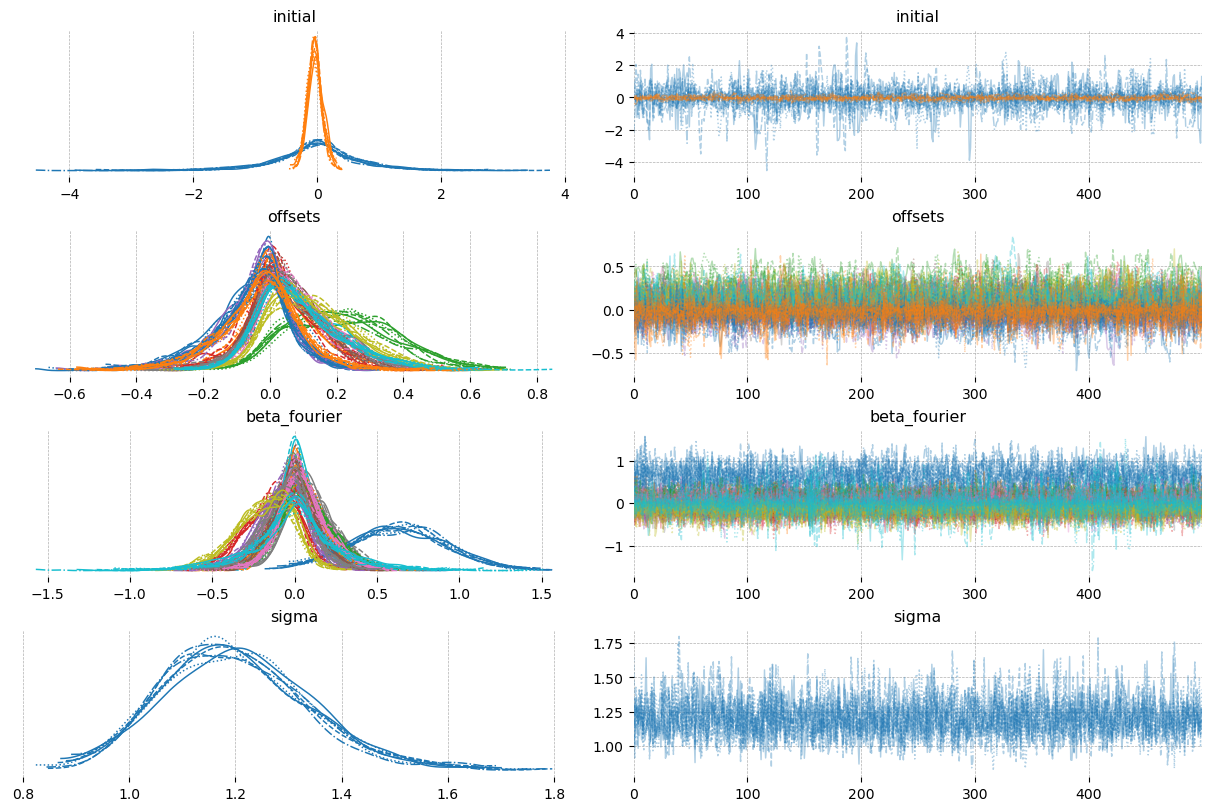

In [47]:
az.plot_trace(seasonality_idata, var_names=['initial', 'offsets', 'beta_fourier', 'sigma']);

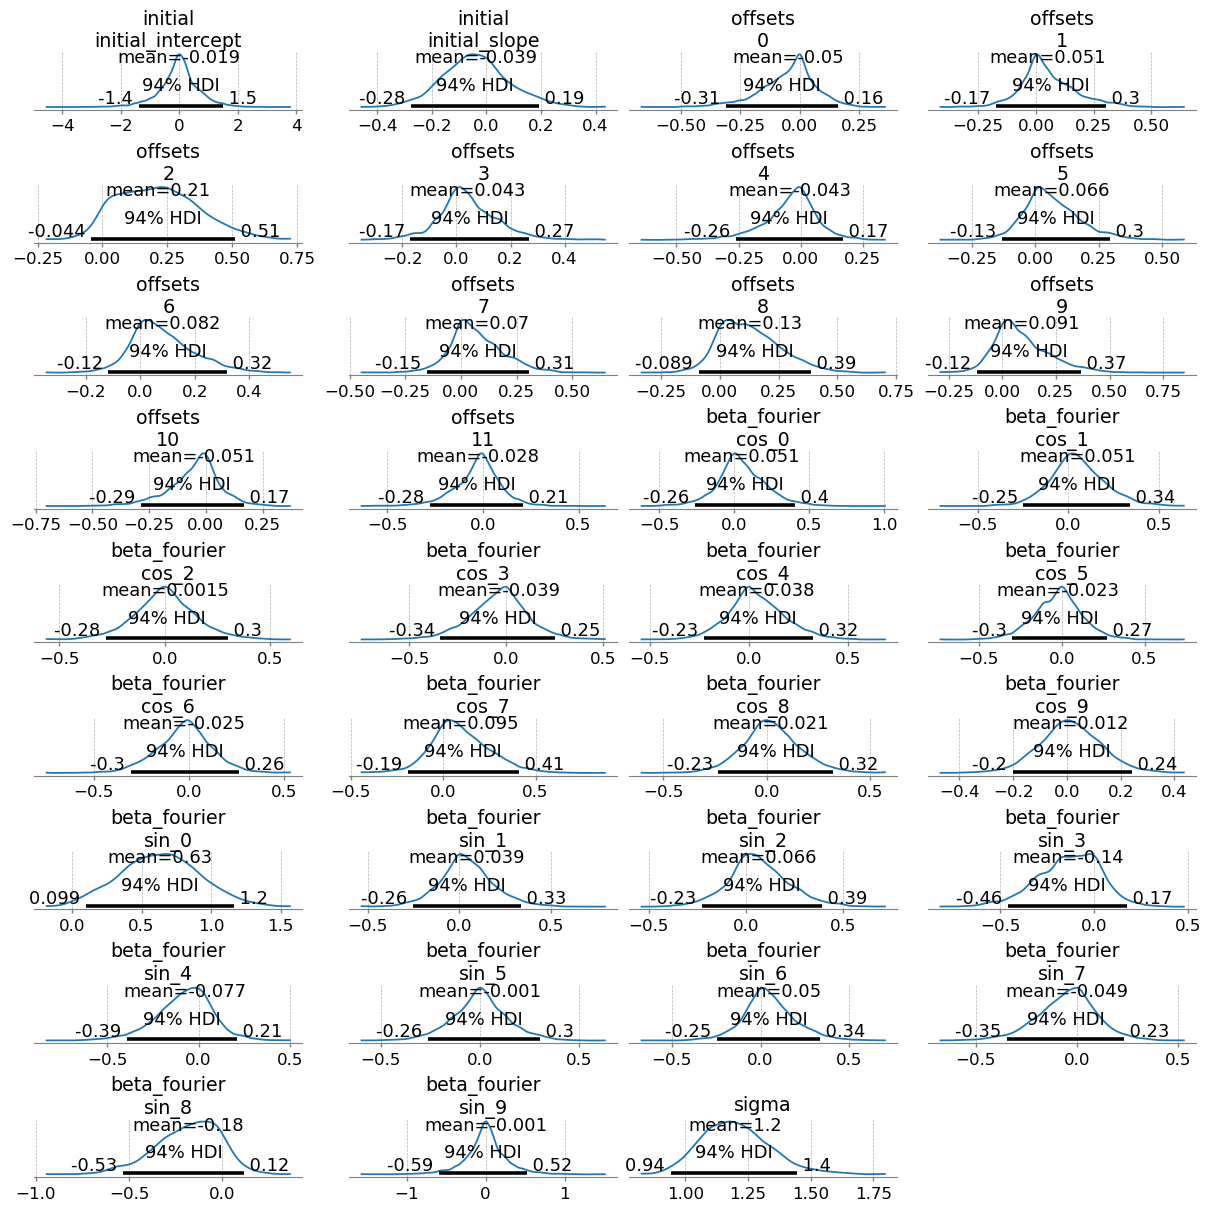

In [48]:
az.plot_posterior(seasonality_idata, 
                  var_names=['initial', 'offsets', 'beta_fourier', 'sigma'], 
                 figsize=(12,12),
                  textsize=12);


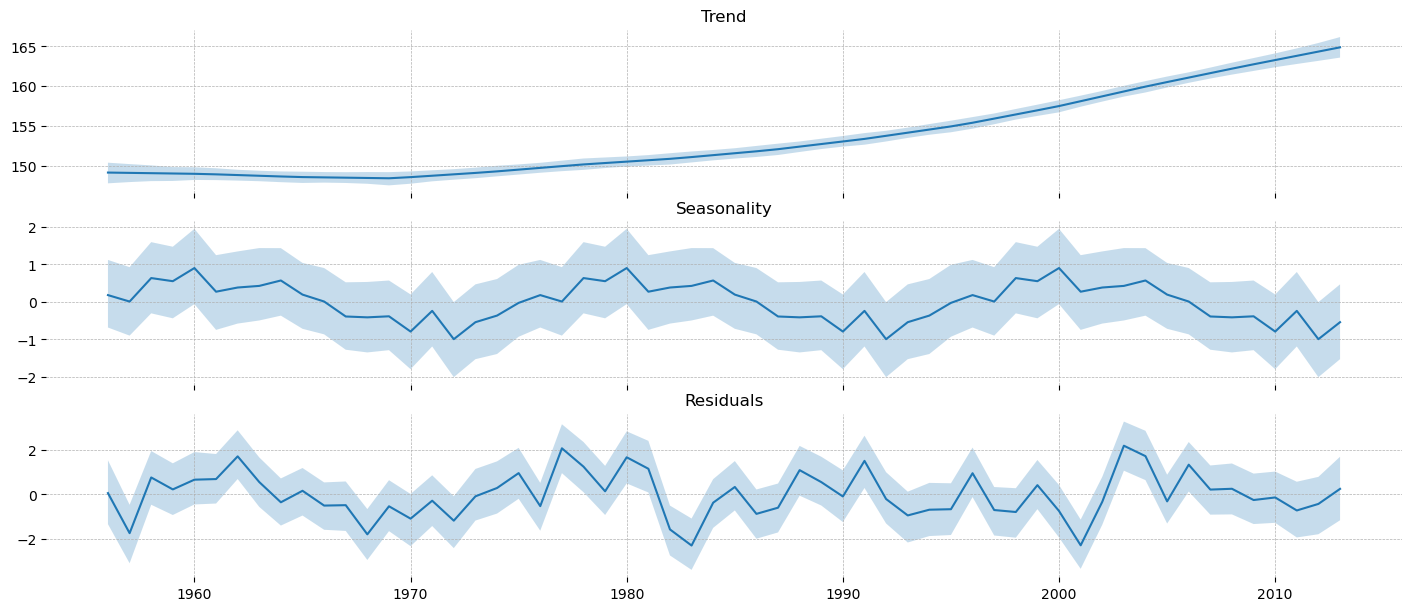

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(14,6), sharex=True)

for axis, variable in zip(fig.axes, ['trend', 'seasonality', 'residuals']):
    # Pull out the component of interest
    data = seasonality_idata.posterior[variable]

    # Compute the mean of the samples
    mu = data.mean(dim=['chain', 'draw'])

    # Compute the HDI ("error bars")
    hdi = az.hdi(data)[variable]

    # Plot them together
    axis.plot(data.time, mu)
    axis.fill_between(data.time, *hdi.values.T, alpha=0.25)
    axis.set_title(variable.title())
plt.show()


In [50]:
forecast_time = np.arange(train_df.shape[0], train_df.shape[0] + test_df.shape[0])
with seasonality_mod:
    pm.set_data({'t':forecast_time}, coords={'time':test_df.index})
    # Set predictions = True to put the out-of-sample predictions into the idata as a group called
    # "predictions" instead of the default "posterior_predictive"
    # (It doesn't do anything else, so don't think it will do some statistical magic for you!)
    seasonality_idata = pm.sample_posterior_predictive(seasonality_idata, predictions=True, **POST_PRED_KWARGS)


Sampling: [y_hat]


Output()

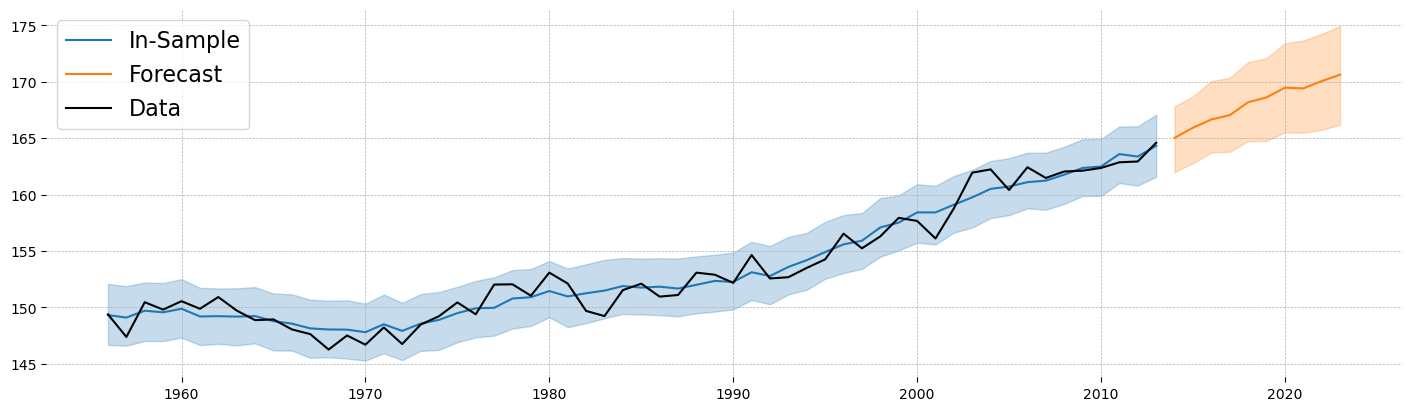

In [51]:
fig, ax = plt.subplots()
for group, var_name, label, var_color in make_plot_iter():
    data = getattr(seasonality_idata, group)
    time_values = data.coords['time'].values
    if group != 'constant_data':
        hdi = az.hdi(data)[var_name]
        data = data.mean(dim=['chain', 'draw'])
        ax.fill_between(time_values, *hdi.values.T, color=var_color, alpha=0.25)
    ax.plot(time_values, data[var_name].values, c=var_color, label=label)
    ax.legend(fontsize=16)

<Axes: xlabel='Date'>

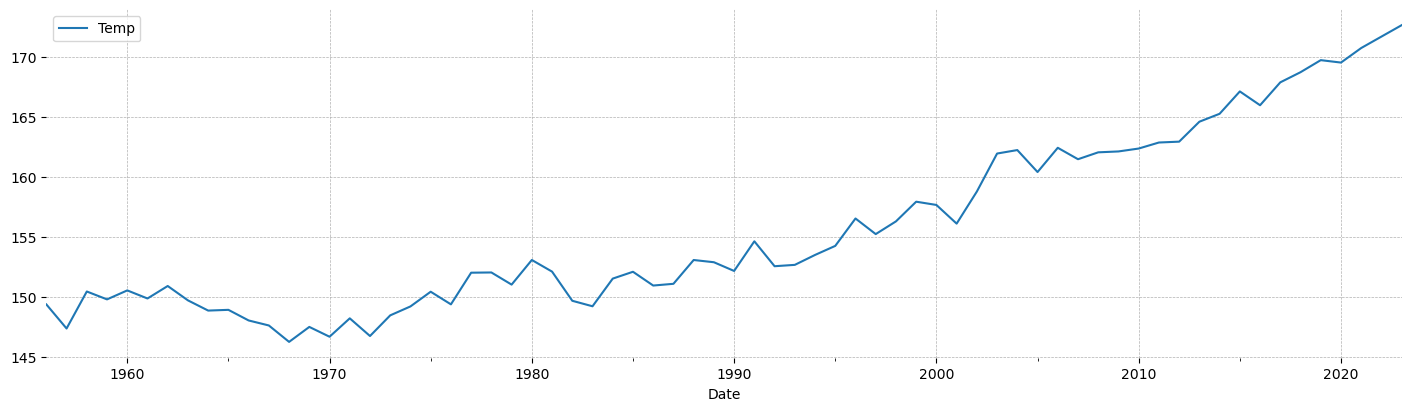

In [52]:
df_ocean.plot()

<Axes: xlabel='Date'>

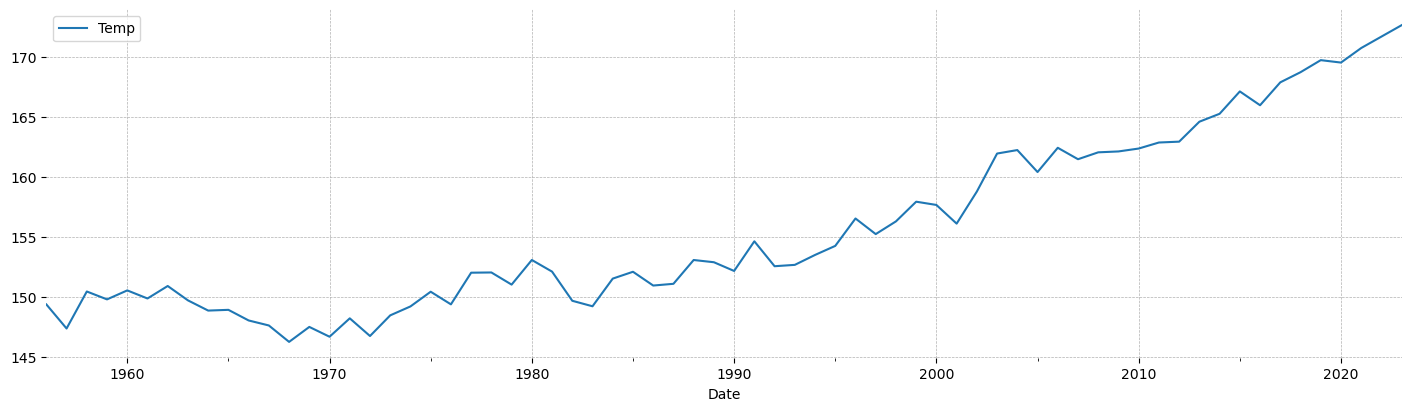

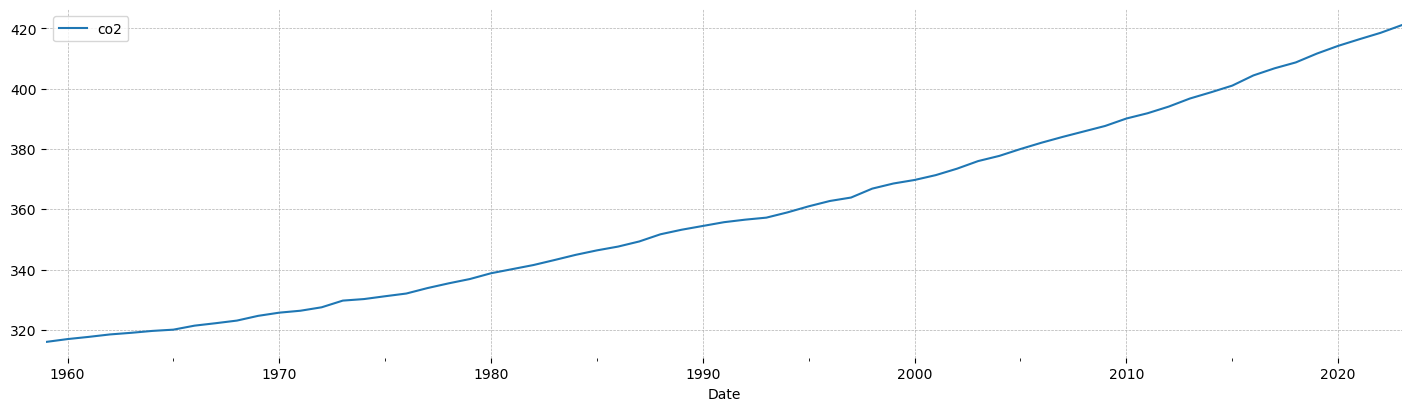

In [53]:
df_ocean.plot()
df_co2.plot()

In [54]:
df = pd.DataFrame.merge(df_ocean,df_co2,how='inner',left_index=True, right_index=True)

In [55]:
df['co2'] = (df['co2'] - df['co2'].mean())/df['co2'].std()
df['Temp'] = (df['Temp'] - df['Temp'].mean())/df['Temp'].std()

<Axes: xlabel='Date'>

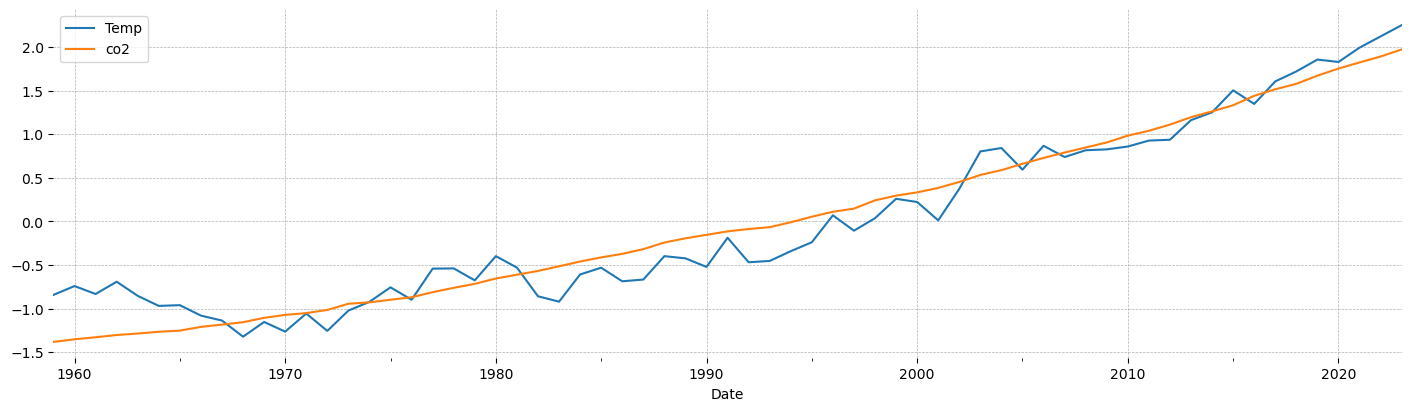

In [56]:
df.plot()

In [57]:
train_df, test_df = df.iloc[:round(len(df)*.85)], df.iloc[round(len(df)*.85):]

n_timesteps = round(train_df)
n_changepoints = round(len(train_df)/5)
p = 20 # Decade cycle
n = 10 # Saturated model

coords = {'params': ['initial_intercept', 'initial_slope'],
          'fourier_features':[f'{func}_{i}' for func in ['cos', 'sin'] for i in range(n)],
          'breakpoint':np.arange(n_changepoints, dtype='int'),
          'time':train_df.index}

SAMPLING_KWARGS = dict(nuts_sampler='nutpie', chains=8, draws=500)

In [58]:
with pm.Model(coords=coords) as seasonality_mod:

    # 1 is Ocean Heat
    # 2 is CO2
    
    y_obs1 = pm.Data('y_obs1', train_df['Temp'].values.ravel())
    y_obs2 = pm.Data('y_obs2', train_df['co2'].values.ravel())
    
    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])
    T_max = t.max().eval()
    A, s = create_piecewise_trend(t, T_max, n_changepoints)
    X_fourier = create_fourier_features(t, n=n, p=p)
    
    initials1 = pm.Laplace('initial1', mu=0, b=0.1, dims=['params'])
    offsets1 = pm.Laplace('offsets1', mu=0, b=0.1, dims=['breakpoint'])
    beta_fourier1 = pm.Laplace('beta_fourier1', mu=0, b=0.1, dims=['fourier_features'])

    initials2 = pm.Laplace('initial2', mu=0, b=0.1, dims=['params'])
    offsets2 = pm.Laplace('offsets2', mu=0, b=0.1, dims=['breakpoint'])
    beta_fourier2 = pm.Laplace('beta_fourier2', mu=0, b=0.1, dims=['fourier_features'])

    alpha1 = pm.Normal('alpha1', mu=-1.5, sigma=1)
    alpha2 = pm.Normal('alpha2', mu=-1.5, sigma=1)
    
    # Save the time series components for later analysis
    intercept1 = pm.Deterministic('intercept1', initials1[0] + ((-s * A) * offsets1).sum(axis=1), dims=['time'])
    slope1 = pm.Deterministic('slope1', initials1[1] + (A * offsets1).sum(axis=1), dims=['time'])
    trend1 = pm.Deterministic('trend1', alpha1 + intercept1 + slope1 * t, dims=['time'])
    seasonality1 = pm.Deterministic('seasonality1', X_fourier @ beta_fourier1, dims=['time'])

    intercept2 = pm.Deterministic('intercept2', initials2[0] + ((-s * A) * offsets2).sum(axis=1), dims=['time'])
    slope2 = pm.Deterministic('slope2', initials2[1] + (A * offsets2).sum(axis=1), dims=['time'])
    trend2 = pm.Deterministic('trend2', alpha2 + intercept2 + slope2 * t, dims=['time'])
    seasonality2 = pm.Deterministic('seasonality2', X_fourier @ beta_fourier2, dims=['time'])

    initialsc = pm.Laplace('initialc', mu=0, b=0.1, dims=['params'])
    offsetsc = pm.Laplace('offsetsc', mu=0, b=0.1, dims=['breakpoint'])    
    interceptc = pm.Deterministic('interceptc', initialsc[0] + ((-s * A) * offsetsc).sum(axis=1), dims=['time'])
    slopec = pm.Deterministic('slopec', initialsc[1] + (A * offsetsc).sum(axis=1), dims=['time'])
    alphac = pm.Normal('alphac', mu=0, sigma=1)
    beta_fourierc = pm.Laplace('beta_fourierc', mu=0, b=0.1, dims=['fourier_features'])

    trendc = pm.Deterministic('trendc', alphac + interceptc + slopec * t, dims=['time'])
    seasonalityc = pm.Deterministic('seasonalityc', X_fourier @ beta_fourierc, dims=['time'])

    mu1 = pm.Deterministic('mu1', trendc + seasonalityc + trend1 + seasonality1, dims=['time'])
    sigma1 = pm.HalfNormal('sigma1', sigma=1)

    mu2 = pm.Deterministic('mu2', trendc + seasonalityc + trend2 + seasonality2, dims=['time'])
    sigma2 = pm.HalfNormal('sigma2', sigma=1)

    y_hat1 = pm.Normal('y_hat1', mu=mu1, sigma=sigma1, observed=y_obs1, shape=t.shape[0], dims=['time'])
    resid1 = pm.Deterministic('residuals1', y_obs1 - mu1, dims=['time'])

    y_hat2 = pm.Normal('y_hat2', mu=mu2, sigma=sigma2, observed=y_obs2, shape=t.shape[0], dims=['time'])
    resid2 = pm.Deterministic('residuals2', y_obs2 - mu2, dims=['time'])
    
    seasonality_idata = pm.sample(**SAMPLING_KWARGS)
    seasonality_idata = pm.compute_log_likelihood(seasonality_idata)
    seasonality_idata = pm.sample_posterior_predictive(seasonality_idata, **POST_PRED_KWARGS)

Output()

Sampling: [y_hat1, y_hat2]


Output()

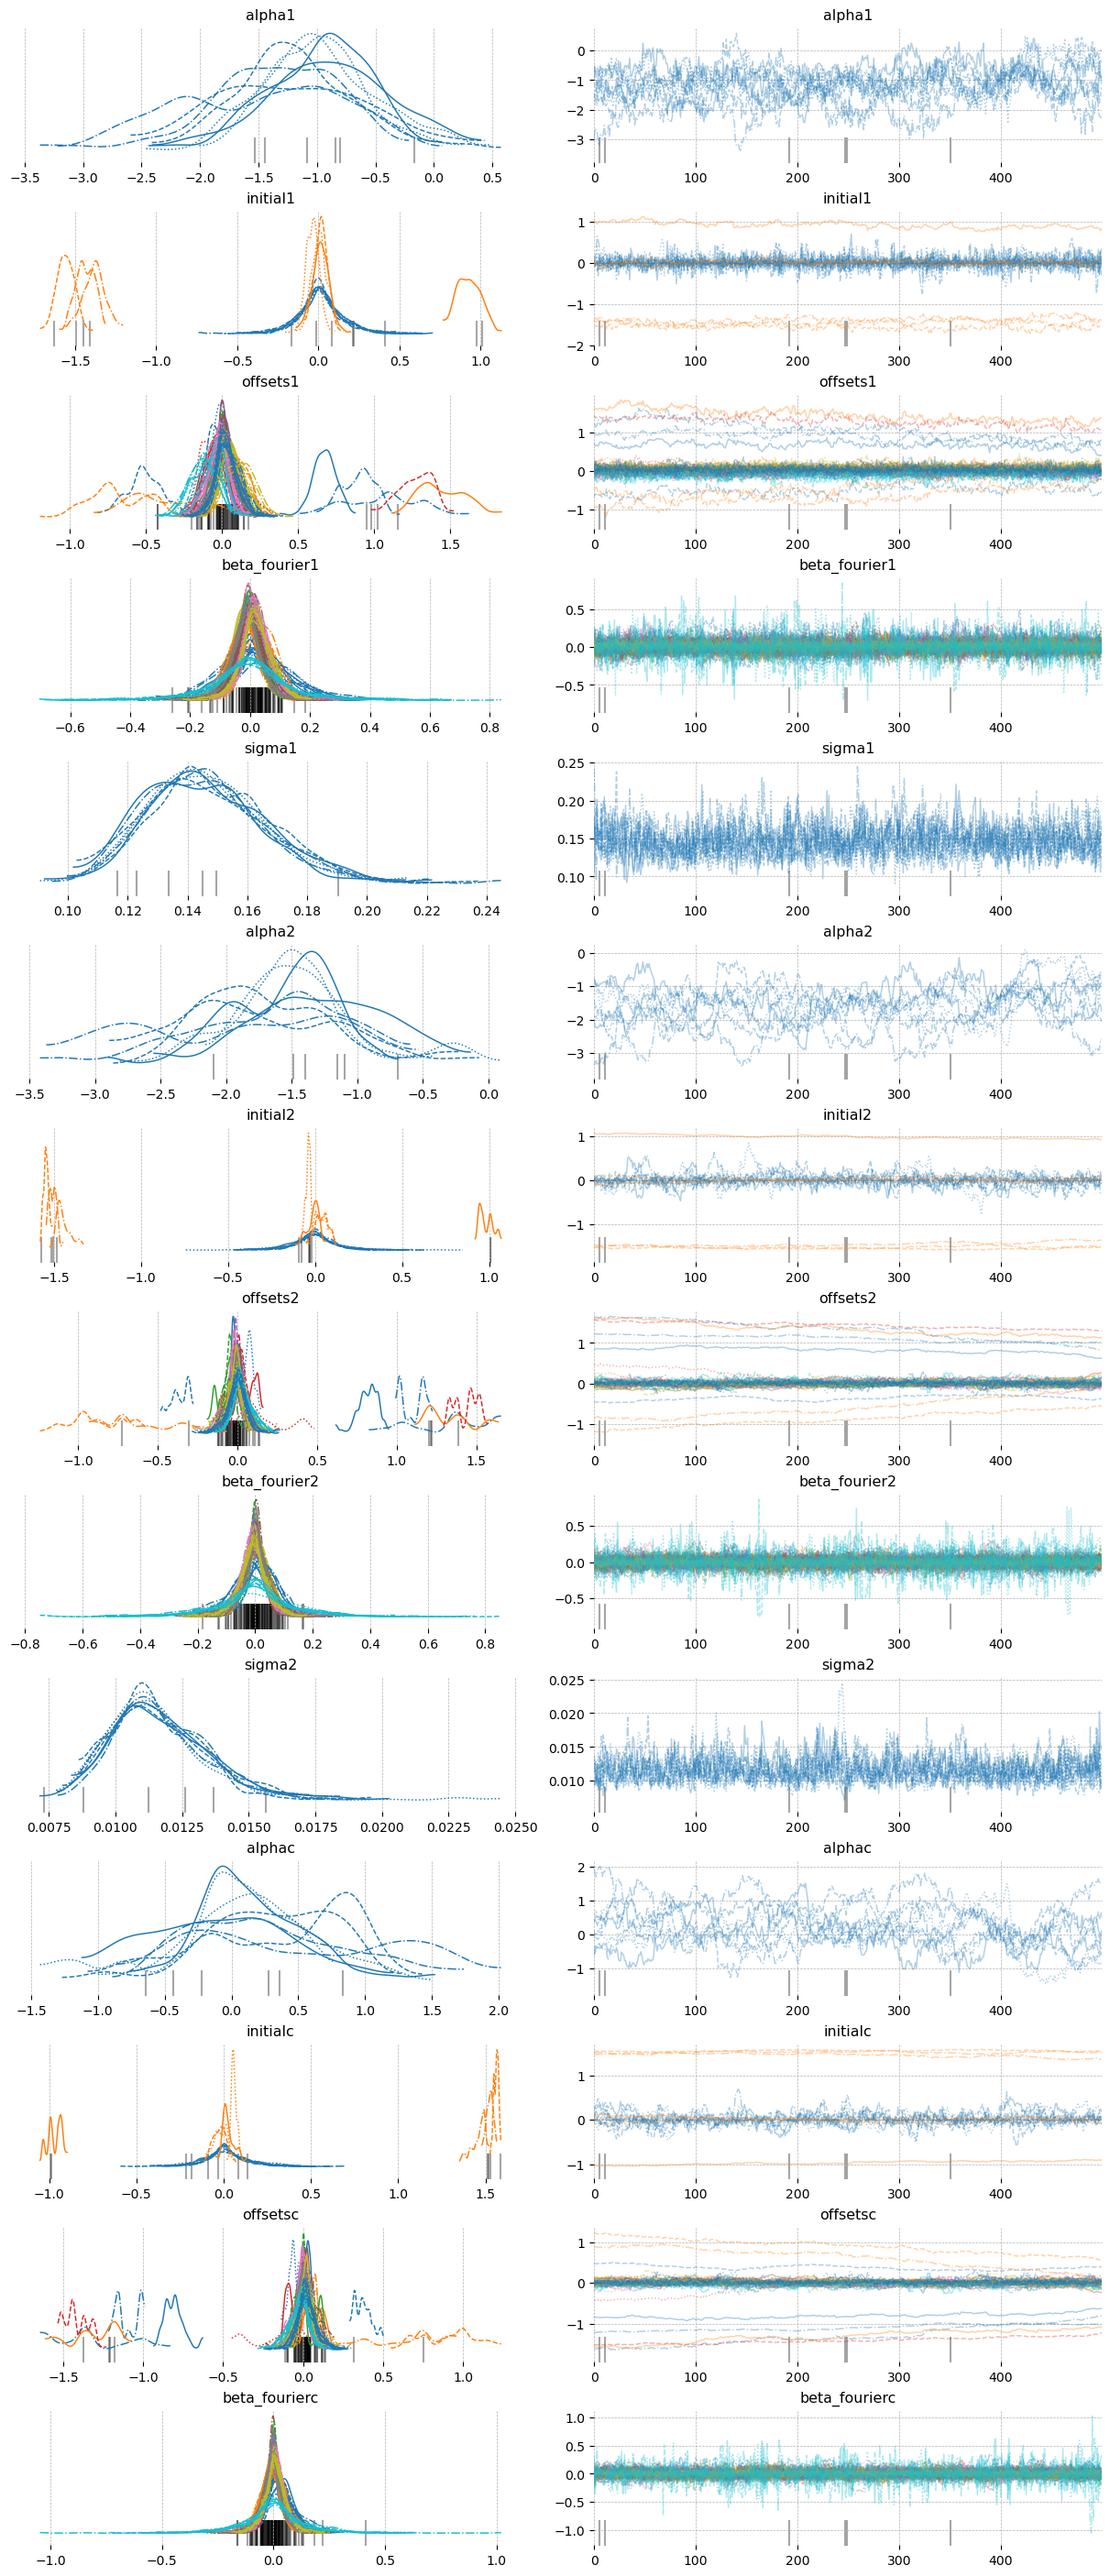

In [59]:
az.plot_trace(seasonality_idata, var_names=['alpha1', 'initial1', 'offsets1', 'beta_fourier1', 'sigma1',
                                            'alpha2', 'initial2', 'offsets2', 'beta_fourier2', 'sigma2',
                                            'alphac', 'initialc', 'offsetsc', 'beta_fourierc']);

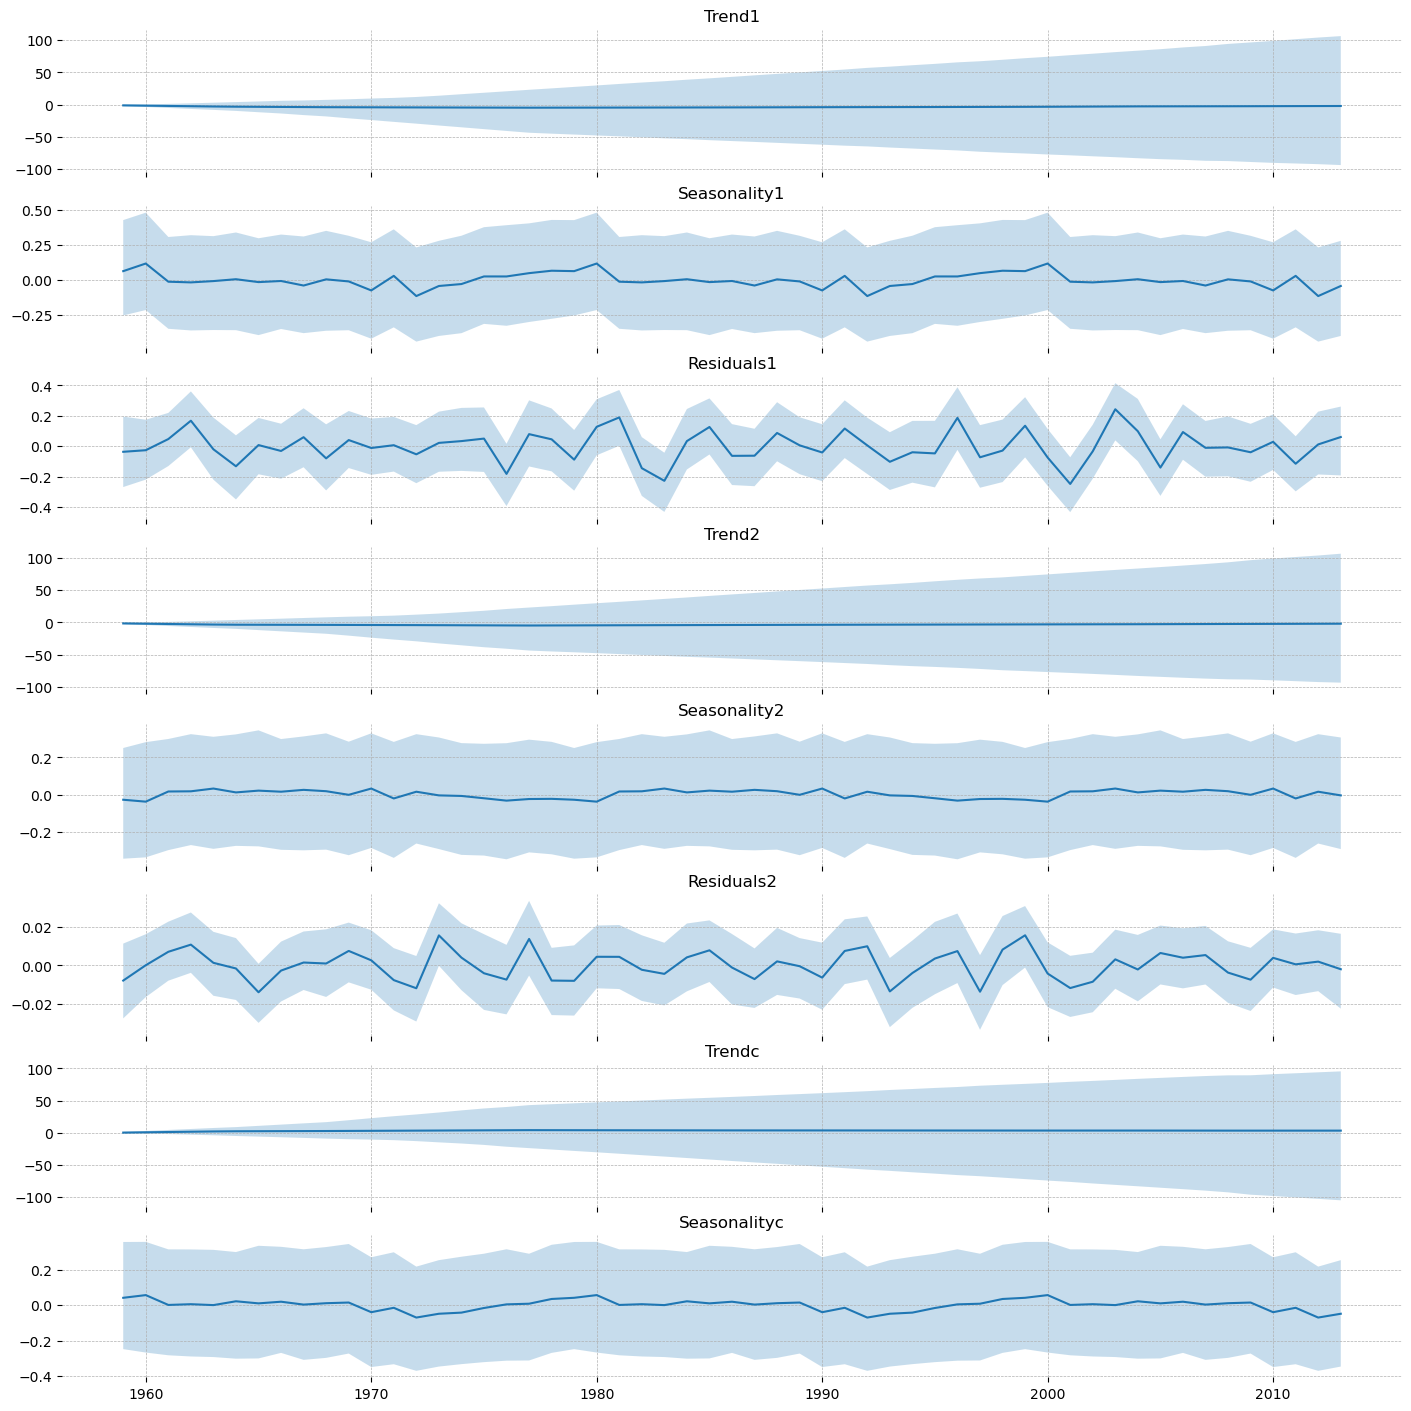

In [60]:
fig, ax = plt.subplots(8, 1, figsize=(14,14), sharex=True)

for axis, variable in zip(fig.axes, ['trend1', 'seasonality1', 'residuals1',
                                     'trend2', 'seasonality2', 'residuals2',
                                     'trendc', 'seasonalityc'
                                    ]):
    # Pull out the component of interest
    data = seasonality_idata.posterior[variable]

    # Compute the mean of the samples
    mu = data.mean(dim=['chain', 'draw'])

    # Compute the HDI ("error bars")
    hdi = az.hdi(data)[variable]

    # Plot them together
    axis.plot(data.time, mu)
    axis.fill_between(data.time, *hdi.values.T, alpha=0.25)
    axis.set_title(variable.title())
plt.savefig('test.png')

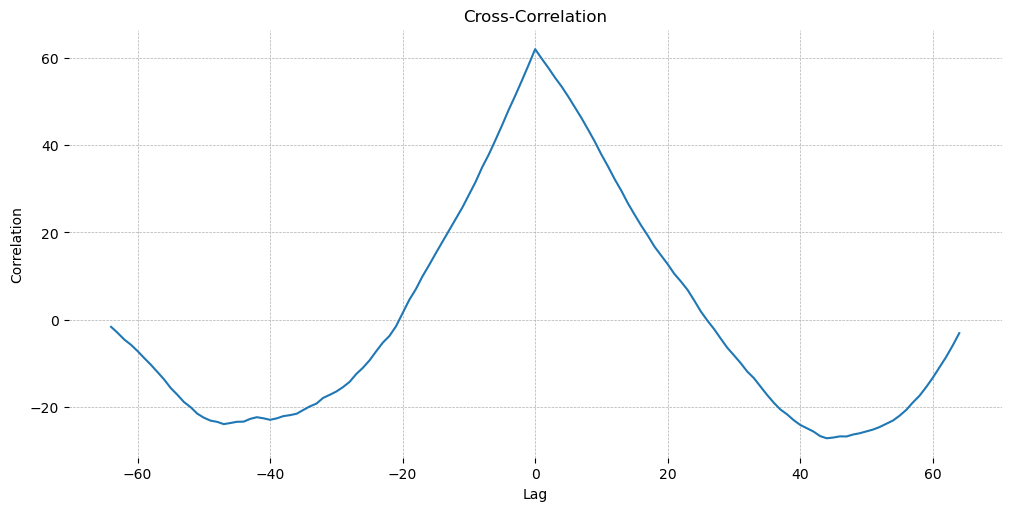

In [61]:
from scipy.signal import correlate

# Cross-correlation
cross_corr = correlate(df['Temp'], df['co2'], mode='full')
lags = np.arange(-len(df['Temp']) + 1, len(df['co2']))

plt.figure(figsize=(10, 5))
plt.plot(lags, cross_corr)
plt.title('Cross-Correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_77008/1172022158.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


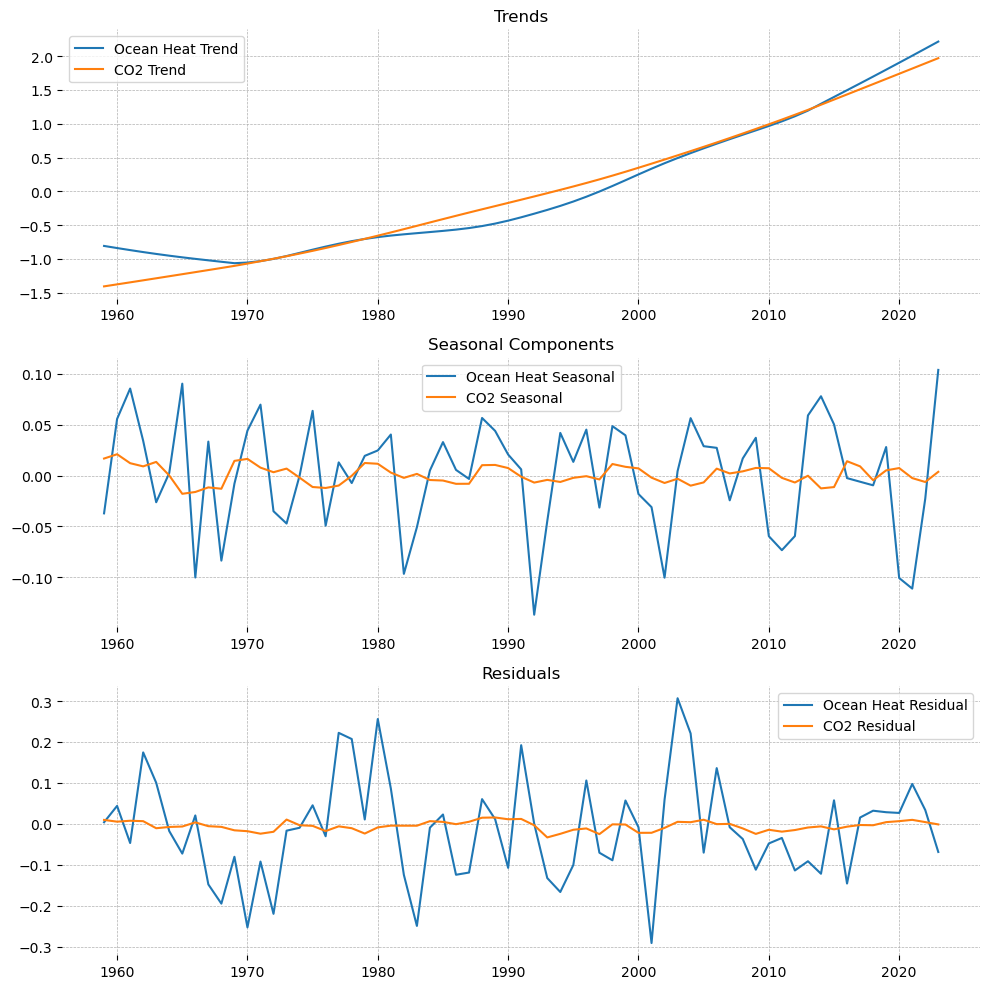

In [62]:
from statsmodels.tsa.seasonal import STL

stl1 = STL(df['Temp'], period=10).fit()
stl2 = STL(df['co2'], period=10).fit()

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(stl1.trend, label='Ocean Heat Trend')
plt.plot(stl2.trend, label='CO2 Trend')
plt.legend()
plt.title('Trends')

plt.subplot(3, 1, 2)
plt.plot(stl1.seasonal, label='Ocean Heat Seasonal')
plt.plot(stl2.seasonal, label='CO2 Seasonal')
plt.legend()
plt.title('Seasonal Components')

plt.subplot(3, 1, 3)
plt.plot(stl1.resid, label='Ocean Heat Residual')
plt.plot(stl2.resid, label='CO2 Residual')
plt.legend()
plt.title('Residuals')

plt.tight_layout()
plt.show()

In [63]:
train_df2 = train_df[['Temp']]
test_df2 = test_df[['Temp']]

In [64]:
with pm.Model(coords=coords) as seasonality_mod:

    # 1 is Ocean Heat
    # 2 is CO2
    
    y_obs1 = pm.Data('y_obs1', train_df2.values.ravel())
    
    t = pm.Data('t', np.arange(train_df2.shape[0]), dims=['time'])
    T_max = t.max().eval()
    
    alpha1 = pm.Normal('alpha1', mu=-1.5, sigma=1)

    beta1 = pm.Normal('beta1', mu=0, sigma=1)

    delta1 = pm.Normal('delta1', mu=0, sigma=1)

    mu1 = pm.Deterministic('mu1', (alpha1) + (beta1)*t + (delta1) * (t **2), dims=['time'])
    sigma1 = pm.HalfNormal('sigma1', sigma=1)

    y_hat1 = pm.Normal('y_hat1', mu=mu1, sigma=sigma1, observed=y_obs1, shape=t.shape[0], dims=['time'])
    resid1 = pm.Deterministic('residuals1', y_obs1 - mu1, dims=['time'])
    
    seasonality_idata = pm.sample(**SAMPLING_KWARGS)
    seasonality_idata = pm.compute_log_likelihood(seasonality_idata)
    seasonality_idata = pm.sample_posterior_predictive(seasonality_idata, **POST_PRED_KWARGS)

Output()

Sampling: [y_hat1]


Output()

In [65]:
forecast_time = np.arange(train_df2.shape[0], train_df2.shape[0] + train_df2.shape[0])
with deterministic_trend_mod:
    pm.set_data({'t':forecast_time}, coords={'time':test_df2.index})
    # Set predictions = True to put the out-of-sample predictions into the idata as a group called
    # "predictions" instead of the default "posterior_predictive"
    # (It doesn't do anything else, so don't think it will do some statistical magic for you!)
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, predictions=True, **POST_PRED_KWARGS)

ShapeError: Length of new coordinate values does not match the new dimension length. (actual 10 != expected 55)

Well, looking at our results I prefer the quadratic model

In [ ]:
# We'll re-use these
def make_plot_iter():
    plotting_groups = ['posterior_predictive', 'predictions', 'constant_data']
    var_names = ['y_hat', 'y_hat', 'y_obs']
    plotting_colors = ['tab:blue', 'tab:orange', 'k']
    labels = ['In-Sample', 'Forecast', 'Data']
    return zip(plotting_groups, var_names, labels, plotting_colors)

fig, ax = plt.subplots()
for group, var_name, label, var_color in make_plot_iter():
    data = getattr(det_trend_idata, group)
    time_values = data.coords['time'].values
    if group != 'constant_data':
        hdi = np.e**az.hdi(data)[var_name]-10
        data = data.mean(dim=['chain', 'draw'])
        ax.fill_between(time_values, *hdi.values.T, color=var_color, alpha=0.25)
    ax.plot(time_values, np.e**data[var_name].values-10, c=var_color, label=label)
    ax.legend(fontsize=16)

In [ ]:
fig, ax = plt.subplots(8, 1, figsize=(14,14), sharex=True)

for axis, variable in zip(fig.axes, ['trend1', 'seasonality1', 'residuals1',
                                     'trend2', 'seasonality2', 'residuals2',
                                     'trendc', 'seasonalityc'
                                    ]):
    # Pull out the component of interest
    data = seasonality_idata.posterior[variable]

    # Compute the mean of the samples
    mu = data.mean(dim=['chain', 'draw'])

    # Compute the HDI ("error bars")
    hdi = az.hdi(data)[variable]

    # Plot them together
    axis.plot(data.time, mu)
    axis.fill_between(data.time, *hdi.values.T, alpha=0.25)
    axis.set_title(variable.title())
plt.savefig('test.png')

In [ ]:
with pm.Model(coords=coords) as seasonality_mod:

    # 1 is Ocean Heat
    # 2 is CO2
    
    y_obs1 = pm.Data('y_obs1', train_df['Temp'].values.ravel())
    y_obs2 = pm.Data('y_obs2', train_df['co2'].values.ravel())
    
    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])
    T_max = t.max().eval()
    
    alpha1 = pm.Normal('alpha1', mu=-1.5, sigma=1)
    alpha2 = pm.Normal('alpha2', mu=-1.5, sigma=1)
    alphac = 0

    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    betac = pm.Normal('betac', mu=1, sigma=1)

    delta1 = pm.Normal('delta1', mu=0, sigma=1)
    delta2 = pm.Normal('delta2', mu=0, sigma=1)
    deltac = pm.Normal('deltac', mu=1, sigma=1)

    mu1 = pm.Deterministic('mu1', (alpha1+alphac) + (beta1+betac)*t + (delta1+deltac) * (t **2), dims=['time'])
    sigma1 = pm.HalfNormal('sigma1', sigma=1)
    mu2 = pm.Deterministic('mu2', (alpha2+alphac) + (beta2+betac)*t + (delta2+deltac) * (t **2), dims=['time'])
    sigma2 = pm.HalfNormal('sigma2', sigma=1)
    muc = pm.Deterministic('muc', alphac + betac*t + deltac * (t **2), dims=['time'])
    sigmac = pm.HalfNormal('sigmac', sigma=1)

    y_hat1 = pm.Normal('y_hat1', mu=mu1, sigma=sigma1, observed=y_obs1, shape=t.shape[0], dims=['time'])
    resid1 = pm.Deterministic('residuals1', y_obs1 - mu1, dims=['time'])

    y_hat2 = pm.Normal('y_hat2', mu=mu2, sigma=sigma2, observed=y_obs2, shape=t.shape[0], dims=['time'])
    resid2 = pm.Deterministic('residuals2', y_obs2 - mu2, dims=['time'])
    
    seasonality_idata = pm.sample(**SAMPLING_KWARGS)
    seasonality_idata = pm.compute_log_likelihood(seasonality_idata)
    seasonality_idata = pm.sample_posterior_predictive(seasonality_idata, **POST_PRED_KWARGS)

In [ ]:
az.plot_trace(seasonality_idata, var_names=['alpha1', 'beta1', 'delta1', 'mu1', 'sigma1',
                                            'alpha2', 'beta2', 'delta2', 'mu2', 'sigma2',
                                            'betac', 'deltac', 'muc', 'sigmac']);